# Assignment 1

#### Imports

In [ ]:
# for google colab
!pip install tqdm emoji gensim umap-learn rapidfuzz wordcloud nltk torchinfo --quiet
!pip install datasets transformers evaluate tf-keras --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import copy, json, re, os, random
from collections import Counter
from typing import List, Callable, Dict
from collections import OrderedDict
import numpy as np
import pandas as pd
from tqdm import tqdm
import emoji
import gensim
from itertools import cycle
import gensim.downloader as gloader
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz
from wordcloud import WordCloud
import gc

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
from torchinfo import summary
import torch.optim as optim
import torch.nn.functional as F

from datasets import Dataset
from evaluate import load

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoConfig
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback

In [ ]:
def fix_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
fix_seed(0)

seeds = [42, 1337, 2025]

In [ ]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords') # for google colab
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##### Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !cp -r "/content/drive/My Drive/Assignment_NLP/A1/data" /content/
!cp -r "/content/drive/My Drive/uni/NLP/data" /content/

!mkdir /content/imgs

## Task 1 - Corpus

**Instructions:**
* **Download** the `A1/data` folder.
* **Load** the three JSON files and encode them as ``pandas.DataFrame``.
* **Aggregate labels** for Task 2 using majority voting and store them in a new dataframe column called `label`. Items without a clear majority will be removed from the dataset.
* **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
* **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `label`.
* **Encode the `label` column**: Use the following mapping
```
{
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
```

**Implementation:**
* We load from the .json files the train, val and test set, applying the required changes.  
* We then proceed to inspect the dataset with some plots.

In [ ]:
def dataset_from_json(name):
    with open(name, 'r', encoding='utf-8') as f:
        data = json.load(f)
        df = pd.DataFrame.from_dict(data, orient='index')
        df = df[['id_EXIST', 'lang', 'tweet', 'labels_task2']]
        df = df.rename(columns={'labels_task2': 'label'})
        df = df[df['lang'] == 'en']

        def most_frequent_or_drop(arr):
            if not isinstance(arr, list):
                return arr
            c = Counter(arr)
            most_common = c.most_common()
            if len(most_common) == 0:
                return None
            max_count = most_common[0][1]
            candidates = [val for val,
                          count in most_common if count == max_count]
            if len(candidates) > 1:
                return None
            return candidates[0]

        df['label'] = df['label'].apply(most_frequent_or_drop)

        def map_label(label):
            mapping = {
                '-': 0,
                'DIRECT': 1,
                'JUDGEMENTAL': 2,
                'REPORTED': 3
            }
            return mapping.get(label, None)

        df = df.dropna(subset=['label'])
        df['label'] = df['label'].apply(map_label)

    return df

In [ ]:
# non preprocessed datasets
train_df_np = dataset_from_json('data/training.json')
val_df_np = dataset_from_json('data/validation.json')
test_df_np = dataset_from_json('data/test.json')

### Dataset inspection

In [ ]:
inspection_df = pd.DataFrame()
inspection_df = pd.concat([train_df_np, val_df_np, test_df_np], ignore_index=True)

# set the set attribute to train, val or test
inspection_df['split'] = ''
inspection_df.loc[:len(train_df_np)-1, 'split'] = 'train'
inspection_df.loc[len(train_df_np):len(train_df_np)+len(val_df_np)-1, 'split'] = 'val'
inspection_df.loc[len(train_df_np)+len(val_df_np):, 'split'] = 'test'

inspection_df.head()

,id_EXIST,lang,tweet,label,split
0,200001,en,FFS! How about laying the blame on the bastard...,0,train
1,200002,en,Writing a uni essay in my local pub with a cof...,3,train
2,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,3,train
3,200004,en,@GMB this is unacceptable. Use her title as yo...,0,train
4,200005,en,‘Making yourself a harder target’ basically bo...,0,train


#### Classes distribution

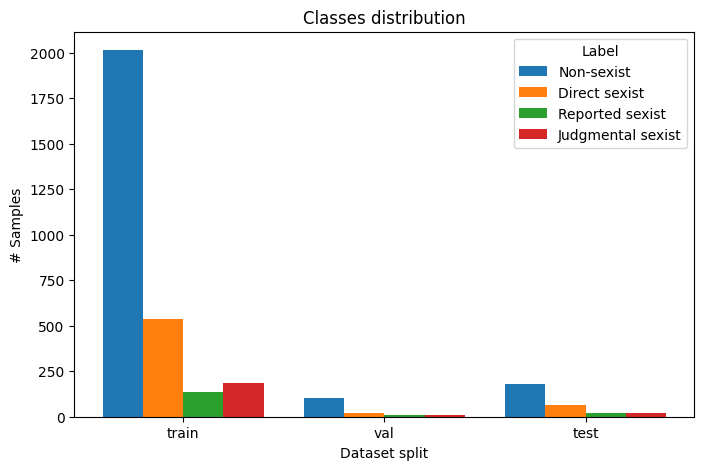

In [ ]:
labels = ['Non-sexist', 'Direct sexist', 'Reported sexist', 'Judgmental sexist']
splits = ['train', 'val', 'test']
counts = {
    label: [
        np.sum((inspection_df.split == split) & (inspection_df.label == i))
        for split in splits
    ]
    for i, label in enumerate(labels)
}
x = np.arange(len(splits))
width = 0.2
plt.figure(figsize=(8, 5))
for i, label in enumerate(labels):
    plt.bar(x + i * width, counts[label], width, label=label)
plt.xticks(x + width * 1.5, splits)
plt.xlabel('Dataset split')
plt.ylabel('# Samples')
plt.title('Classes distribution')
plt.legend(title='Label')
plt.show()


#### Tweet length distribution

100%|██████████| 280/280 [00:00<00:00, 6137.18it/s]


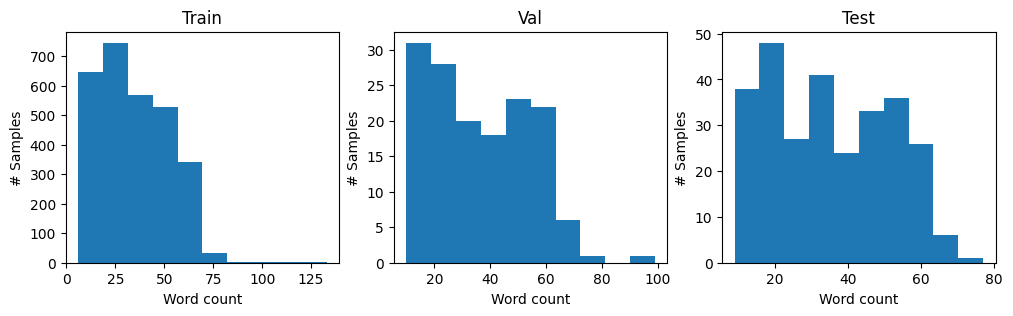

In [ ]:
train_texts = inspection_df[inspection_df.split == 'train'].tweet.values
val_texts = inspection_df[inspection_df.split == 'val'].tweet.values
test_texts = inspection_df[inspection_df.split == 'test'].tweet.values

train_lengths = [len(word_tokenize(text)) for text in tqdm(train_texts)]
val_lengths = [len(word_tokenize(text)) for text in tqdm(val_texts)]
test_lengths = [len(word_tokenize(text)) for text in tqdm(test_texts)]

plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist([train_lengths, val_lengths, test_lengths][i])
    plt.xlabel('Word count')
    plt.ylabel('# Samples')
    plt.title(['Train', 'Val', 'Test'][i])


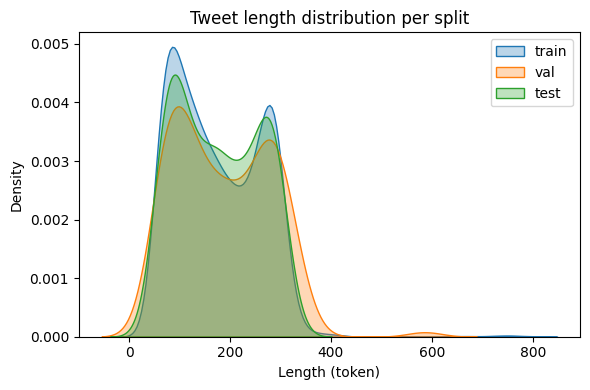

In [ ]:
inspection_df["length"] = inspection_df["tweet"].apply(len)

plt.figure(figsize=(6,4))

for split in inspection_df["split"].unique():
    sns.kdeplot(
        inspection_df[inspection_df["split"] == split]["length"],
        label=split,
        fill=True,
        alpha=0.3
    )

plt.title("Tweet length distribution per split")
plt.xlabel("Length (token)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

#### Visualize the classes

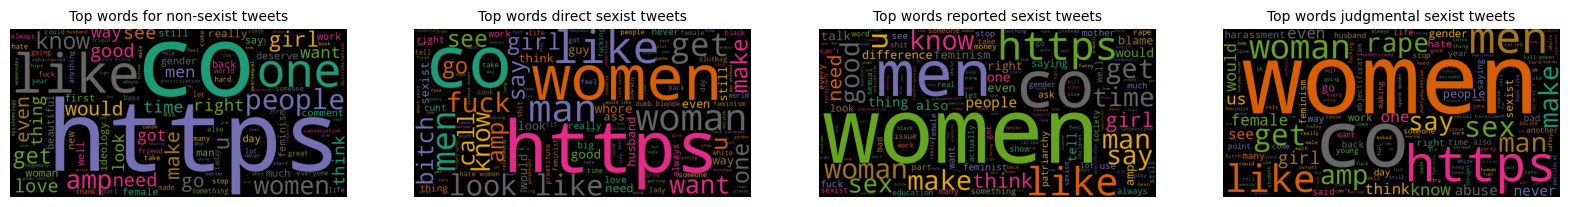

In [ ]:
n_posts = 1000
stop = set(stopwords.words('english'))
q_NS = ' '.join(inspection_df[inspection_df['label'] == 0]['tweet'].str.lower().values[:n_posts])
q_DS = ' '.join(inspection_df[inspection_df['label'] == 1]['tweet'].str.lower().values[:n_posts])
q_RS = ' '.join(inspection_df[inspection_df['label'] == 2]['tweet'].str.lower().values[:n_posts])
q_JS = ' '.join(inspection_df[inspection_df['label'] == 3]['tweet'].str.lower().values[:n_posts])

wordcloud_NS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_NS)
wordcloud_DS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_DS)
wordcloud_RS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_RS)
wordcloud_JS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_JS)

fig, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].imshow(wordcloud_NS)
ax[0].set_title('Top words for non-sexist tweets',fontsize = 10)
ax[0].axis("off")

ax[1].imshow(wordcloud_DS)
ax[1].set_title('Top words direct sexist tweets',fontsize = 10)
ax[1].axis("off")

ax[2].imshow(wordcloud_RS)
ax[2].set_title('Top words reported sexist tweets',fontsize = 10)
ax[2].axis("off")

ax[3].imshow(wordcloud_JS)
ax[3].set_title('Top words judgmental sexist tweets',fontsize = 10)
ax[3].axis("off")

plt.show()

## Task 2 - Data Cleaning

**Instructions:**
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

**Implementation:**
* We apply the processign pipeline to the datasets and visualize the resulting token distribution

In [ ]:
stop_words = set(stopwords.words('english'))  # enhlish stopwords set

def clean_text(text: str) -> str:
    """Remove emojis, URLs, mentions, hashtags, special characters, extra spaces, and stopwords."""
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')  # remove emojis
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)  # remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = re.sub(r'["\'`\’\‘\“\”]', ' ', text)  # remove extra quotes

    # remove stopwords
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words).strip()

def lemmatize_text(text: str) -> str:
    """Lemmatize text using POS tagging for more accurate results."""
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    words = text.split()
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)

def text_preprocessing(df, column='tweet', pipeline=None):
    """
    Apply a sequence of preprocessing functions to a dataframe column.

    Parameters:
    - df: pandas DataFrame
    - column: name of the text column
    - pipeline: list of functions to apply sequentially
    """
    df = df.copy()
    if pipeline is None:
        pipeline = [clean_text, lemmatize_text]

    for func in pipeline:
        df[column] = df[column].apply(func)

    return df

In [ ]:
pipeline = [clean_text, lemmatize_text]

train_df = text_preprocessing(train_df_np, pipeline=pipeline)
val_df = text_preprocessing(val_df_np, pipeline=pipeline)
test_df = text_preprocessing(test_df_np, pipeline=pipeline)

### Dataset inspection

In [ ]:
inspection_df = pd.DataFrame()
inspection_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# set the set attribute to train, val or test
inspection_df['split'] = ''
inspection_df.loc[:len(train_df)-1, 'split'] = 'train'
inspection_df.loc[len(train_df):len(train_df)+len(val_df)-1, 'split'] = 'val'
inspection_df.loc[len(train_df)+len(val_df):, 'split'] = 'test'

inspection_df.head()

,id_EXIST,lang,tweet,label,split
0,200001,en,ffs lay blame bastard murder novel idea know,0,train
1,200002,en,write uni essay local pub coffee random old ma...,3,train
2,200003,en,dont appreciate two ride team member look behi...,3,train
3,200004,en,unacceptable use title men interview fact seni...,0,train
4,200005,en,make hard target basically boil make sure targ...,0,train


#### Token distribution

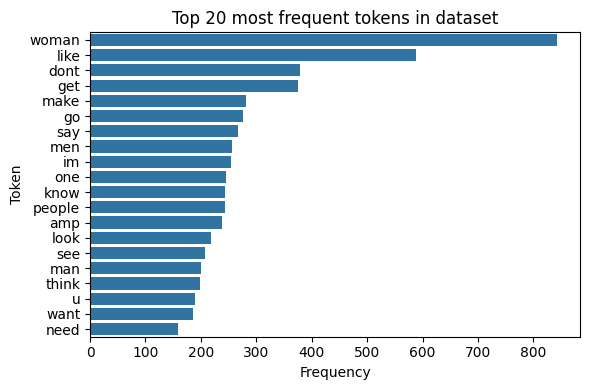

In [ ]:
inspection_df["tokens"] = inspection_df["tweet"].apply(lambda x: [t for t in x.split() if t not in stop_words])
all_tokens = [token for sublist in inspection_df["tokens"] for token in sublist]
freq_dist = Counter(all_tokens).most_common(20)   # top 20 tokens

tokens, counts = zip(*freq_dist)

plt.figure(figsize=(6,4))
sns.barplot(x=list(counts), y=list(tokens))
plt.title("Top 20 most frequent tokens in dataset")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.tight_layout()
plt.show()

## Task 3 - Text Encoding

**Instructions:**
* Embed words using **GloVe embeddings**, using any embedding dimension.
* All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
* For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., ``<UNK>``) and a **static** embedding.
* You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



**Implementation:**
* We first build, evaluate and save the **vocabulary** to file.  
* Then we check the number of OOV words using the chosen GloVe embedding dim (50).  
* We embed the vocabulary with one of the proposed strategies for OOV words and visualize the result.  
* Finally we compare all the different possibilities for OOV words handling.  

### Build the vocabulary

In [ ]:
def build_vocabulary(
    df: pd.DataFrame,
    column_name: str = "tweet",
    add_special_tokens: bool = True
):
    """
    Builds a complete vocabulary from a DataFrame column.
    Returns mappings (idx_to_word, word_to_idx), word listing, and frequency DataFrame.

    Parameters:
    - df: DataFrame containing the text column.
    - column_name: Name of the column to process.
    - add_special_tokens: Whether to include <PAD> and <UNK> tokens.
    Returns:
    - idx_to_word (OrderedDict[int, str])
    - word_to_idx (OrderedDict[str, int])
    - word_listing (List[str])
    - vocab_df (pd.DataFrame with 'vocabulary' and 'counts')
    """

    # Builds a list tokens from the tweets
    text_array = df[column_name].values
    list_of_token_lists = [t.split() for t in text_array]
    repeated_vocab = np.concatenate(list_of_token_lists)
    repeated_vocab = repeated_vocab[repeated_vocab != ""]  # removes empty strings

    # Counts the frequency of each word
    token_array, counts_array = np.unique(repeated_vocab, return_counts=True)

    # Sorts by descending frequency
    sorted_indices = np.argsort(-counts_array)
    token_array = token_array[sorted_indices].tolist()
    counts_array = counts_array[sorted_indices]

    # Creates ordered mappings
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 0

    if add_special_tokens:
        for tok in ["<PAD>", "<UNK>"]:
            word_to_idx[tok] = curr_idx
            idx_to_word[curr_idx] = tok
            curr_idx += 1

    for token in tqdm(token_array, desc="Building vocabulary"):
        word_to_idx[token] = curr_idx
        idx_to_word[curr_idx] = token
        curr_idx += 1

    # Builds word listing and DataFrame
    word_listing = list(idx_to_word.values())
    vocab_df = pd.DataFrame({"vocabulary": token_array, "counts": counts_array})

    return idx_to_word, word_to_idx, word_listing, vocab_df

In [ ]:
idx_to_word, word_to_idx, word_listing, vocab_df = build_vocabulary(train_df)

print("Size:", len(word_to_idx))
print("Most common words:\n", vocab_df.head(10))
print("Example mapping:", list(word_to_idx.items())[:10])

Building vocabulary: 100%|██████████| 9457/9457 [00:00<00:00, 1492419.78it/s]

Size: 9459
Most common words:
   vocabulary  counts
0      woman     734
1       like     509
2        get     334
3       dont     322
4       make     246
5         go     242
6        say     237
7        men     225
8         im     222
9       know     218
Example mapping: [('<PAD>', 0), ('<UNK>', 1), ('woman', 2), ('like', 3), ('get', 4), ('dont', 5), ('make', 6), ('go', 7), ('say', 8), ('men', 9)]


#### Evaluate the vocabulary

In [ ]:
def evaluate_vocabulary(
    idx_to_word: Dict[int, str],
    word_to_idx: Dict[str, int],
    word_listing: List[str],
    df: pd.DataFrame,
    check_default_size: bool = False
):
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    _, _, first_word_listing, _ = build_vocabulary(df)
    _, _, second_word_listing, _ = build_vocabulary(df)
    assert first_word_listing == second_word_listing

In [ ]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, train_df)
print("")
print("Evaluation completed!")

Vocabulary evaluation...


Building vocabulary: 100%|██████████| 9457/9457 [00:00<00:00, 1757912.29it/s]


Evaluation completed!


#### Save the vocabulary

In [ ]:
vocab_path = './data/vocab.json'

print(f"Saving vocabulary to {vocab_path}")
with open(vocab_path, mode='w') as f:
    json.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to ./data/vocab.json
Saving completed!


### OOV words

In [ ]:
embedding_dimension = 50
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
embedding_model = gloader.load(download_path)

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    Parameters:
    - embedding_model: pre-trained word embedding model (gensim wrapper)
    - word_listing: dataset specific vocabulary (list)
    Returns:
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")
print(oov_terms[:3])

Total OOV terms: 1719 (18.17%)
['mfngl', 'childrenwhich', 'zonei']


### Embedding

The proposed solutions to handle an OOV word are:
- **context:** the embedding is obtained averaging the embeddings of its context words.
- **mean:** the embedding is the average of all the known embeddings.
- **subwords:** the embedding is obtained averaging the embeddings of its subwords.
- **similarity:** the embedding is obtained as the average of its neighbors in the embedding space.
- **random:** the embedding is randomly sampled.

#### OOVs embedding strategies

In [ ]:
def embedding_from_context(train_df, word, embedding_matrix, context_size=3, embedding_dimension=50):
    """Generate an embedding for an oov word as average of its context in the training data."""
    try:
        for seq in train_df.tweet.values:
            tokens = seq.split()
            if word in tokens:
                pos = tokens.index(word)
                start = max(0, pos - context_size)
                end = min(len(tokens), pos + context_size + 1)
                context_words = [t for t in tokens[start:end] if t != word]
                break
        context_embeddings = []
        for context_word in context_words:
            try:
                context_embeddings.append(embedding_matrix[word_to_idx[context_word]])
            except KeyError:
                # if the context word is also oov, skip it
                continue
        if not len(context_embeddings) > 2:
            raise ValueError("Not enough context embeddings found")

        embedding = np.mean(context_embeddings, axis=0)
    except Exception as e:
        embedding = np.random.uniform(low=-3, high=3, size=embedding_dimension)
    return embedding

In [ ]:
def embedding_as_subwords(word, glove, n=3):
    """Generate an embedding for an oov word as average of its subwords."""
    subwords = [word[i:i+n] for i in range(len(word)-n+1)]
    known_subs = [glove[sub] for sub in subwords if sub in glove]
    if known_subs:
        return np.mean(known_subs, axis=0)
    else:
        return np.mean(glove.vectors, axis=0)  # fallback: average vector

In [ ]:
def embedding_from_similarity(word, glove, scorer='ratio', top_k=1, min_score=70):
    """Generate an embedding for an oov word as average of its neighbors in the embedding space."""
    vocab_list = glove.index_to_key
    scorer_fn = getattr(fuzz, scorer)
    # Find top_k closest matches by fuzzy similarity
    matches = process.extract(word, vocab_list, limit=top_k, scorer=scorer_fn)
    # Filter out low-similarity matches
    valid_matches = [(w, s) for w, s, _ in matches if s >= min_score]

    if not valid_matches:
        return np.mean(glove.vectors, axis=0)

    # Weighted average of matched embeddings by similarity score
    vectors, weights = [], []
    for w, score in valid_matches:
        vectors.append(glove[w])
        weights.append(score)

    weights = np.array(weights) / np.sum(weights)
    return np.average(vectors, axis=0, weights=weights)

#### Embedding matrix

In [ ]:
def build_embedding_matrix(
    embedding_model,
    embedding_dimension: int,
    word_to_idx: Dict[str, int],
    vocab_size: int,
    oov_terms: List[str] = None,
    unk_token: str = "<UNK>",
    oov_strategy: str = "random",
    random_seed: int = 42
) -> torch.Tensor:
    """
    Builds an embedding matrix for a dataset, handling OOV and <UNK> tokens.
    Parameters:
    - embedding_model: pre-trained word embeddings (GloVe)
    - embedding_dimension: dimensionality of embeddings
    - word_to_idx: dictionary mapping words to indices
    - vocab_size: total vocabulary size
    - oov_terms: list of OOV terms from training set
    - unk_token: token used for unseen words in val/test
    - random_seed: for reproducibility of random embeddings
    Returns: embedding matrix (torch.Tensor) of shape [vocab_size, embedding_dimension]
    """
    np.random.seed(random_seed)
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    # Precompute a random vector for <UNK>
    unk_vector = np.random.uniform(-0.05, 0.05, embedding_dimension).astype(np.float32)

    for word, idx in tqdm(word_to_idx.items(), desc="Building embedding matrix"):
        if word == unk_token:
            embedding_matrix[idx] = unk_vector
        else:
            try:
                embedding_vector = embedding_model[word]
            except KeyError:
                # OOV word
                if oov_strategy == "context":
                    embedding_vector = embedding_from_context(train_df, word, embedding_matrix, context_size=5)
                elif oov_strategy == "mean":
                    mean_embedding = np.mean(embedding_matrix, axis=0)
                    noise = np.random.normal(0, 1, mean_embedding.shape)
                    embedding_vector = mean_embedding + noise
                elif oov_strategy == "subwords" and embedding_model is not None:
                    embedding_vector = embedding_as_subwords(word, embedding_model, n=3)
                elif oov_strategy == "similarity" and embedding_model is not None:
                    embedding_vector = embedding_from_similarity(word, embedding_model, top_k=3)
                else:   # oov_strategy == "random"
                    embedding_vector = np.random.uniform(-0.05, 0.05, embedding_dimension).astype(np.float32)

            embedding_matrix[idx] = embedding_vector

    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
    return embedding_matrix

In [ ]:
vocab_size = len(word_to_idx)

embedding_matrix = build_embedding_matrix(
    embedding_model=embedding_model,
    embedding_dimension=embedding_dimension,
    word_to_idx=word_to_idx,
    vocab_size=vocab_size,
    oov_terms=oov_terms,
    unk_token="<UNK>",
    oov_strategy="subwords",
)

print()
print(embedding_matrix.shape)  # [vocab_size, embedding_dim]

Building embedding matrix: 100%|██████████| 9459/9459 [00:00<00:00, 12459.01it/s]


torch.Size([9459, 50])


#### Co-occurrence matrix

In [ ]:
def co_occurrence_count(df: pd.DataFrame,
                        idx_to_word: Dict[int, str],
                        word_to_idx: Dict[str, int],
                        window_size: int = 4) -> np.ndarray:
    """
    Builds word-word co-occurrence matrix based on word counts.
    Parameters:
    - df: DataFrame containing the text column.
    - idx_to_word: mapping from indices to words.
    - word_to_idx: mapping from words to indices.
    - window_size: size of the context window.
    Returns: co_occurrence symmetric matrix of size |V| x |V|
    """
    vocab_size = len(idx_to_word)
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size),
                                    dtype=np.float32)
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for pos, token in enumerate(tokens):
            start = max(0, pos - window_size)
            end = min(pos + window_size + 1, len(tokens))

            first_word_index = word_to_idx[token]
            for pos2 in range(start, end):
                if pos2 != pos:
                    second_token = tokens[pos2]
                    second_word_index = word_to_idx[second_token]
                    co_occurrence_matrix[first_word_index,
                                         second_word_index] += 1
    return co_occurrence_matrix

In [ ]:
co_occurrence_matrix = co_occurrence_count(train_df,
                                           idx_to_word,
                                           word_to_idx,
                                           window_size=4)

100%|██████████| 2873/2873 [00:00<00:00, 4682.69it/s]


### Embedding Visualization

In [ ]:
def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations: List[str] = None,
                         word_to_idx: Dict[str, int] = None):
    """
    Plots given reduce word embeddings (2D). Users can highlight specific words (word_annotations list).

    Parameters:
    - embeddings: word embedding matrix of shape (words, 2) retrieved via a dimensionality reduction technique.
    - word_annotations: list of words to be annotated.
    - word_to_idx: vocabulary map (word -> index) (dict)
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    if word_annotations:
        print(f"Annotating words: {word_annotations}")

        word_indexes = []
        for word in word_annotations:
            word_index = word_to_idx[word]
            word_indexes.append(word_index)

        word_indexes = np.array(word_indexes)

        other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
        target_embeddings = embeddings[word_indexes]

        ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

        for word, word_index in zip(word_annotations, word_indexes):
            word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
            ax.annotate(word, xy=(word_x, word_y))
    else:
        ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

    # We avoid outliers ruining the visualization if they are quite far away
    axis_x_limit = (np.min(embeddings[:, 0]), np.max(embeddings[:, 0]))
    axis_y_limit = (np.min(embeddings[:, 1]), np.max(embeddings[:, 1]))
    plt.xlim(left=axis_x_limit[0] - 0.5, right=axis_x_limit[1] + 0.5)
    plt.ylim(bottom=axis_y_limit[0] - 0.5, top=axis_y_limit[1] + 0.5)
    ax.set_xlim(axis_x_limit[0], axis_x_limit[1])
    ax.set_ylim(axis_y_limit[0], axis_y_limit[1])
    plt.show()

In [ ]:
def reduce_SVD(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies SVD dimensionality reduction.

    Parameters:
    - embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).

    Returns:
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
    svd = TruncatedSVD(n_components=2, n_iter=10)
    reduced = svd.fit_transform(embeddings)

    return reduced

def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies UMAP dimensionality reduction.

    Parameters:
    - embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).
    Returns:
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
    umap_emb = umap.UMAP(n_components=2, metric='cosine')
    reduced = umap_emb.fit_transform(embeddings)

    return reduced

In [ ]:
def run_visualization(method_name: str,
                      words_list: List[str],
                      word_to_idx: Dict[str, int],
                      co_occurrence_matrix):
    method_name = method_name.lower().strip()
    method_map = {
        'svd': reduce_SVD,
        'umap': reduce_umap
    }

    if method_name not in method_map:
        raise RuntimeError(f'Invalid method name! Got {method_name}.')

    reduced = method_map[method_name](co_occurrence_matrix)
    visualize_embeddings(reduced, words_list, word_to_idx)

Annotating words: ['leftover', 'celebration', 'creatives']


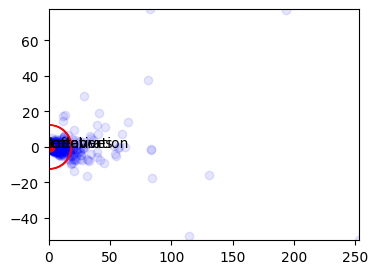

In [ ]:
rand_words = np.random.choice(list(word_to_idx.keys()), size=3, replace=False).tolist()
run_visualization('svd',rand_words, word_to_idx, co_occurrence_matrix)

Annotating words: ['leftover', 'celebration', 'creatives']


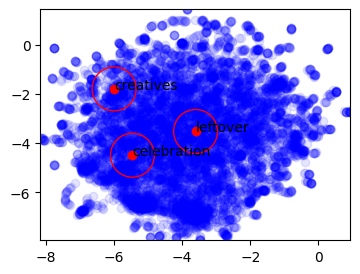

In [ ]:
run_visualization('umap',rand_words, word_to_idx, co_occurrence_matrix)

### Test all oov embedding strategies


Building embedding matrix with OOV strategy: random


100%|██████████| 2873/2873 [00:00<00:00, 7130.69it/s]


Annotating words: ['prostitutionwow', 'consume', 'trojan']


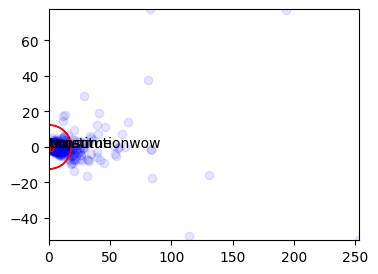

Annotating words: ['prostitutionwow', 'consume', 'trojan']


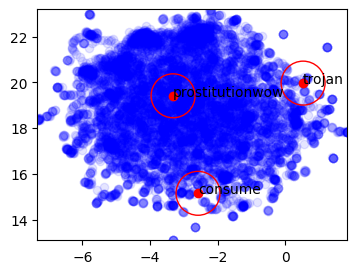


Building embedding matrix with OOV strategy: context


100%|██████████| 2873/2873 [00:00<00:00, 6534.07it/s]


Annotating words: ['sympathy', 'chefayo', 'ref']


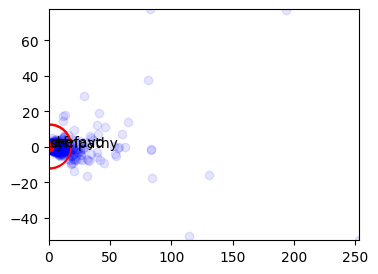

Annotating words: ['sympathy', 'chefayo', 'ref']


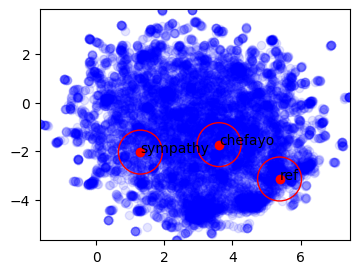


Building embedding matrix with OOV strategy: mean


100%|██████████| 2873/2873 [00:00<00:00, 6907.80it/s]


Annotating words: ['agender', 'best', 'scripture']


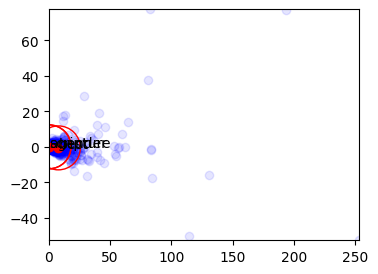

Annotating words: ['agender', 'best', 'scripture']


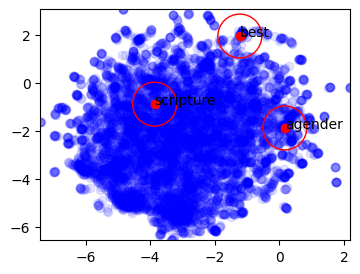


Building embedding matrix with OOV strategy: subwords


100%|██████████| 2873/2873 [00:00<00:00, 7009.79it/s]


Annotating words: ['leftover', 'celebration', 'creatives']


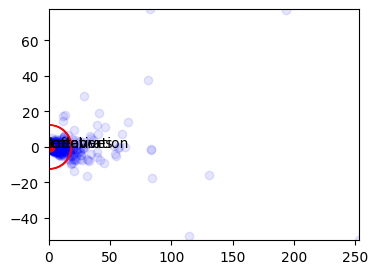

Annotating words: ['leftover', 'celebration', 'creatives']


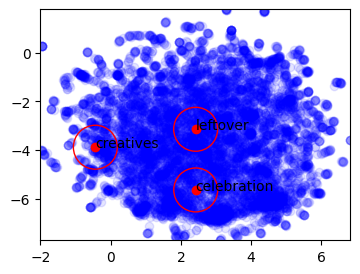


Building embedding matrix with OOV strategy: similarity


100%|██████████| 2873/2873 [00:00<00:00, 6203.99it/s]


Annotating words: ['leftover', 'celebration', 'creatives']


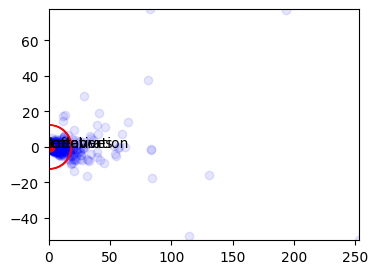

Annotating words: ['leftover', 'celebration', 'creatives']


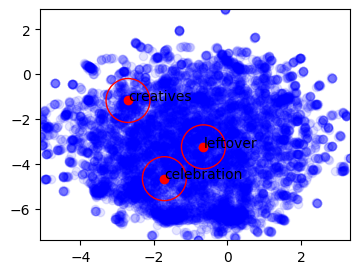

In [ ]:
for strategy in ['random', 'context', 'mean', 'subwords', 'similarity']:
    print(f"\nBuilding embedding matrix with OOV strategy: {strategy}")
    embedding_matrix = build_embedding_matrix(
        embedding_model=embedding_model,
        embedding_dimension=embedding_dimension,
        word_to_idx=word_to_idx,
        vocab_size=vocab_size,
        oov_terms=oov_terms,
        unk_token="<UNK>",
        oov_strategy=strategy,
    )

    co_occurrence_matrix = co_occurrence_count(train_df,
                                            idx_to_word,
                                            word_to_idx,
                                            window_size=4)

    rand_words = np.random.choice(list(word_to_idx.keys()), size=3, replace=False).tolist()
    run_visualization('svd',rand_words, word_to_idx, co_occurrence_matrix)
    run_visualization('umap',rand_words, word_to_idx, co_occurrence_matrix)

## Task 4 - Model definition

**Instructions:**
* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* **Stacked**: add an additional Bidirectional LSTM layer to the Baseline model.

**Implementation:**
* First we make the Dataloader objects from the processed datasets.
* We then define the `BiLSTMClassifier` class, with a customizable number of LSTM layers to create both the baseline and stacked model.
* For comparison we also define a `BiGRUClassifier`, with the same structure except for the recurrent layer architecture.

For all the models an Embedding layer has been used to encode tokens.  

In [ ]:
batch_size = 16
hidden_dim = 128

def text_to_indices(text, word_to_idx, unk_token="<UNK>"):
    """Convert text to a list of indices based on the word_to_idx mapping."""
    return [word_to_idx.get(t, word_to_idx[unk_token]) for t in text.split()]

### Tweet Dataset

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, df, word_to_idx, unk_token="<UNK>"):
        self.sequences = [text_to_indices(t, word_to_idx, unk_token) for t in df['tweet'].values]
        self.labels = df['label'].values.astype(int)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

    def __getitems__(self, indices):
        return [(self.sequences[i], self.labels[i]) for i in indices]

# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_seqs = rnn_utils.pad_sequence([torch.tensor(seq) for seq in sequences],
                                         batch_first=True, padding_value=word_to_idx["<PAD>"])
    labels = torch.tensor(labels)
    return padded_seqs, labels, lengths


train_loader = DataLoader(TweetDataset(train_df, word_to_idx), batch_size=batch_size,
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TweetDataset(val_df, word_to_idx), batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(TweetDataset(test_df, word_to_idx), batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)

### Bidirectional LSTM model

In [ ]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_classes=4, num_layers=1, dropout=0.3, freeze_embeddings=False):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embeddings, padding_idx=word_to_idx["<PAD>"])
        self.bilstm = nn.LSTM(input_size=embedding_dim,
                              hidden_size=hidden_dim,
                              num_layers=num_layers,
                              bidirectional=True,
                              batch_first=True,
                              dropout=dropout if num_layers>1 else 0)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(),
                                                      batch_first=True,
                                                      enforce_sorted=False)
            packed_out, (h_n, c_n) = self.bilstm(packed)
        else:
            # without lengths use full sequences
            out, (h_n, c_n) = self.bilstm(embedded)

        # hidden state concatenation
        h_forward = h_n[-2,:,:]
        h_backward = h_n[-1,:,:]
        h = torch.cat((h_forward, h_backward), dim=1)
        out = self.fc(h)
        return out

In [ ]:
baseline_model = BiLSTMClassifier(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, num_classes=4, num_layers=1, dropout=0.3)

In [ ]:
# max_string_length = train_df_stats['string_length'].max()
max_string_length = 230
print(f"Lunghezza massima del tweet in caratteri: {max_string_length}")

summary(baseline_model, input_size=(16, max_string_length), dtypes=[torch.long])

Lunghezza massima del tweet in caratteri: 230


Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMClassifier                         [16, 4]                   --
├─Embedding: 1-1                         [16, 230, 50]             472,950
├─LSTM: 1-2                              [16, 230, 256]            184,320
├─Linear: 1-3                            [16, 4]                   1,028
Total params: 658,298
Trainable params: 658,298
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 685.88
Input size (MB): 0.03
Forward/backward pass size (MB): 9.01
Params size (MB): 2.63
Estimated Total Size (MB): 11.67

### Bidirectional GRU model

In [ ]:
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_classes=4, num_layers=1, dropout=0.3):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix,
            freeze=False,
            padding_idx=word_to_idx["<PAD>"]
        )

        self.bigru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)

        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded,
                lengths.cpu(),
                batch_first=True,
                enforce_sorted=False
            )
            packed_out, h_n = self.bigru(packed)
        else:
            out, h_n = self.bigru(embedded)

        # h_n shape: (num_layers * num_directions, batch, hidden_dim)
        h_forward = h_n[-2, :, :]
        h_backward = h_n[-1, :, :]

        h = torch.cat((h_forward, h_backward), dim=1)

        return self.fc(h)

In [ ]:
baseline_bigru_model = BiGRUClassifier(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, num_classes=4, num_layers=1, dropout=0.3)

In [ ]:
# max_string_length = train_df_stats['string_length'].max()
max_string_length = 230
print(f"Lunghezza massima del tweet in caratteri: {max_string_length}")

summary(baseline_bigru_model, input_size=(16, max_string_length), dtypes=[torch.long])

Lunghezza massima del tweet in caratteri: 230


Layer (type:depth-idx)                   Output Shape              Param #
BiGRUClassifier                          [16, 4]                   --
├─Embedding: 1-1                         [16, 230, 50]             472,950
├─GRU: 1-2                               [16, 230, 256]            138,240
├─Linear: 1-3                            [16, 4]                   1,028
Total params: 612,218
Trainable params: 612,218
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 516.31
Input size (MB): 0.03
Forward/backward pass size (MB): 9.01
Params size (MB): 2.45
Estimated Total Size (MB): 11.49

## Task 5 - Training and Evaluation

**Instructions:**
* Pick **at least** three seeds for robust estimation.
* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute macro F1-score, precision, and recall metrics on the validation set.
* Report average and standard deviation measures over seeds for each metric.
* Pick the **best** performing model according to the observed validation set performance (use macro F1-score).

**Implementation:**
* We define the functions to train and evaluate our models.
* We then train the buLSTM many times with different hyperparameters:
    - testing the effect of stacking RNN layers
    - testing the fluctuation of the metrics as the seed varies
    - testing different OOVs strategies
    - comparing it to the biGRU model
* We also provide some visualizations to better evaluate the results.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters definition
num_epochs = 10
lr = 1e-4

Using device: cuda


#### Training functions

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    """
    Train the model for one epoch.

    Parameters:
      - model: the neural network model
      - loader: DataLoader for training data
      - optimizer: optimizer for updating model parameters
      - criterion: loss function
      - device: CPU or GPU
    Returns:
      - average loss and accuracy for the epoch
    """
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for batch in loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])

    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, acc

def eval_epoch(model, loader, criterion, device):
    """
    Evaluate the model for one epoch.
    Parameters:
      - model: the neural network model
      - loader: DataLoader for validation/data
      - criterion: loss function
      - device: CPU or GPU
    Returns:
      - average loss, accuracy, precision, recall, and F1-score for the epoch
    """
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs, labels, lengths = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])

    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=np.nan) if len(all_labels) else 0.0
    rec = recall_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0
    f1 = f1_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, acc, prec, rec, f1

def train_loop(model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=True):
    """
    Perform the model training.
    Parameters:
      - model: the neural network model
      - num_epochs: number of training epochs
      - train_loader: DataLoader for training data
      - val_loader: DataLoader for validation data
      - optimizer: optimizer for updating model parameters
      - criterion: loss function
      - device: CPU or GPU
      - verbose: whether to print progress
    Returns:
      - history: dictionary containing training and validation metrics per epoch
    """
    best_val_acc = 0.0
    best_state = None
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_prec': [],
        'val_rec': [],
        'val_f1': [],
    }

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_prec, val_rec, val_f1 = eval_epoch(model, val_loader, criterion, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)
        history['val_f1'].append(val_f1)

        if verbose:
            print(f"Epoch {epoch}/{num_epochs} — train loss: {train_loss:.4f} — val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, val prec: {val_prec:.4f}, val rec: {val_rec:.4f}, val f1: {val_f1:.4f}")

    return history

#### Evaluation function

In [ ]:
def eval_model(model, loader, device, return_ys=False):
    """
    Evaluate the model.
    Parameters:
      - model: the neural network model
      - loader: DataLoader for evaluation data
      - device: CPU or GPU
      - return_ys: whether to return labels and predictions
    Returns:
      - accuracy, precision, recall, and F1-score
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs, labels, lengths = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            outputs = model(inputs, lengths)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])

    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=np.nan) if len(all_labels) else 0.0
    rec = recall_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0
    f1 = f1_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0

    if return_ys:
        return acc, prec, rec, f1, (all_labels, all_preds)
    else:
        return acc, prec, rec, f1


### BiLSTM model

#### Compare RNN layers impact

In [ ]:
# Baseline model definition
base_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=1)
base_model.to(device)
bi_stacked_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=2)
bi_stacked_model.to(device)
tri_stacked_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=3)
tri_stacked_model.to(device)

base_optimizer = optim.Adam(base_model.parameters(), lr=lr)
bi_stacked_optimizer = optim.Adam(bi_stacked_model.parameters(), lr=lr)
tri_stacked_optimizer = optim.Adam(tri_stacked_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Train and Evaluation
base_model_history = train_loop(base_model, num_epochs, train_loader, val_loader, base_optimizer, criterion, device, verbose=False)
base_report = eval_model(base_model, val_loader, device)
bi_stacked_model_history = train_loop(bi_stacked_model, num_epochs, train_loader, val_loader, bi_stacked_optimizer, criterion, device, verbose=False)
bi_stacked_report = eval_model(bi_stacked_model, val_loader, device)
tri_stacked_model_history = train_loop(tri_stacked_model, num_epochs, train_loader, val_loader, tri_stacked_optimizer, criterion, device, verbose=False)
tri_stacked_report = eval_model(tri_stacked_model, val_loader, device)

In [ ]:
print("Single layer training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(base_report[0], base_report[1], base_report[2], base_report[3]))
print("Bi-stacked layers training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(bi_stacked_report[0], bi_stacked_report[1], bi_stacked_report[2], bi_stacked_report[3]))
print("Tri-stacked layers training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(tri_stacked_report[0], tri_stacked_report[1], tri_stacked_report[2], tri_stacked_report[3]))

Single layer training: 
Accuracy: 0.7200, Precision: 0.4665, Recall: 0.3265, F1: 0.3245
Bi-stacked layers training: 
Accuracy: 0.7400, Precision: 0.5795, Recall: 0.4145, F1: 0.4191
Tri-stacked layers training: 
Accuracy: 0.7067, Precision: 0.4783, Recall: 0.3502, F1: 0.3479


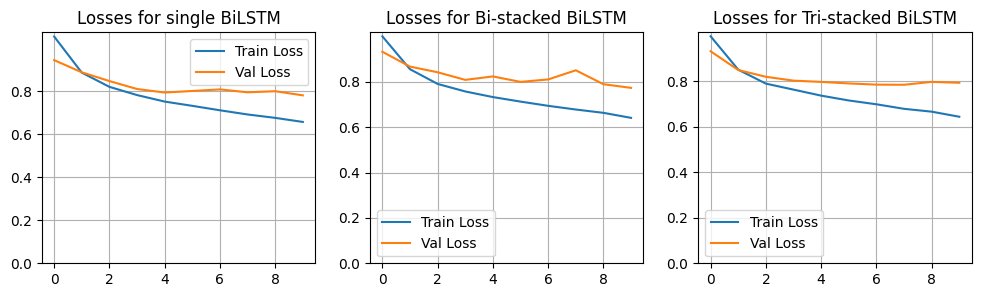

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(base_model_history['train_loss'], label='Train Loss')
plt.plot(base_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Losses for single BiLSTM')
plt.grid()
plt.legend()
plt.subplot(1,3,2)
plt.plot(bi_stacked_model_history['train_loss'], label='Train Loss')
plt.plot(bi_stacked_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Losses for Bi-stacked BiLSTM')
plt.grid()
plt.legend()
plt.subplot(1,3,3)
plt.plot(tri_stacked_model_history['train_loss'], label='Train Loss')
plt.plot(tri_stacked_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Losses for Tri-stacked BiLSTM')
plt.grid()
plt.legend()
plt.show()

#### Training and Evaluation over many seeds

In [ ]:
best_model = None
best_history = None
criterion = nn.CrossEntropyLoss()
training_report = {'baseline': [], 'stacked': []}
best_f1 = 0

for seed in seeds:  # try 3 different random seeds
    print(f"\nRandom seed: {seed}")
    fix_seed(seed)
    baseline_model = BiLSTMClassifier(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, num_layers=1)
    baseline_model.to(device)
    optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
    baseline_model_history = train_loop(baseline_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
    training_report['baseline'].append(eval_model(baseline_model, test_loader, device))
    print("Baseline training: ")
    print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(training_report['baseline'][-1][0], training_report['baseline'][-1][1], training_report['baseline'][-1][2], training_report['baseline'][-1][3]))
    if baseline_model_history['val_f1'][-1] > best_f1:
        best_f1 = baseline_model_history['val_f1'][-1]
        best_model = copy.deepcopy(baseline_model)
        best_history = baseline_model_history

    stacked_model = BiLSTMClassifier(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, num_layers=2)
    stacked_model.to(device)
    optimizer = optim.Adam(stacked_model.parameters(), lr=lr)
    stacked_model_history = train_loop(stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
    training_report['stacked'].append(eval_model(stacked_model, val_loader, device))
    print("Stacked training: ")
    print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(training_report['stacked'][-1][0], training_report['stacked'][-1][1], training_report['stacked'][-1][2], training_report['stacked'][-1][3]))
    if stacked_model_history['val_f1'][-1] > best_f1:
        best_f1 = stacked_model_history['val_f1'][-1]
        best_model = copy.deepcopy(stacked_model)
        best_history = stacked_model_history

    # print("========================================")


Random seed: 42
Baseline training: 
Accuracy: 0.6679, Precision: 0.5381, Recall: 0.3427, F1: 0.3469
Stacked training: 
Accuracy: 0.7200, Precision: 0.5350, Recall: 0.3535, F1: 0.3601

Random seed: 1337
Baseline training: 
Accuracy: 0.6714, Precision: 0.5635, Recall: 0.3494, F1: 0.3573
Stacked training: 
Accuracy: 0.7333, Precision: 0.5186, Recall: 0.3652, F1: 0.3637

Random seed: 2025
Baseline training: 
Accuracy: 0.6679, Precision: 0.5392, Recall: 0.3480, F1: 0.3524
Stacked training: 
Accuracy: 0.7200, Precision: 0.5597, Recall: 0.3535, F1: 0.3615


In [ ]:
for idx, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    baseline_scores = [run[idx] for run in training_report['baseline']]
    stacked_scores = [run[idx] for run in training_report['stacked']]
    print(f"{metric} - Baseline: Mean = {np.mean(baseline_scores):.4f}, Std Dev = {np.std(baseline_scores):.4f} | Stacked: Mean = {np.mean(stacked_scores):.4f}, Std Dev = {np.std(stacked_scores):.4f}")

Accuracy - Baseline: Mean = 0.6690, Std Dev = 0.0017 | Stacked: Mean = 0.7244, Std Dev = 0.0063
Precision - Baseline: Mean = 0.5469, Std Dev = 0.0117 | Stacked: Mean = 0.5378, Std Dev = 0.0169
Recall - Baseline: Mean = 0.3467, Std Dev = 0.0029 | Stacked: Mean = 0.3574, Std Dev = 0.0056
F1 - Baseline: Mean = 0.3522, Std Dev = 0.0042 | Stacked: Mean = 0.3618, Std Dev = 0.0015


In [ ]:
# save the best model
torch.save(best_model.state_dict(), 'best_bilstm.pt')

#### Visualizations for the best model

##### Evaluation metrics

Precision, Recall, F1 over the epochs

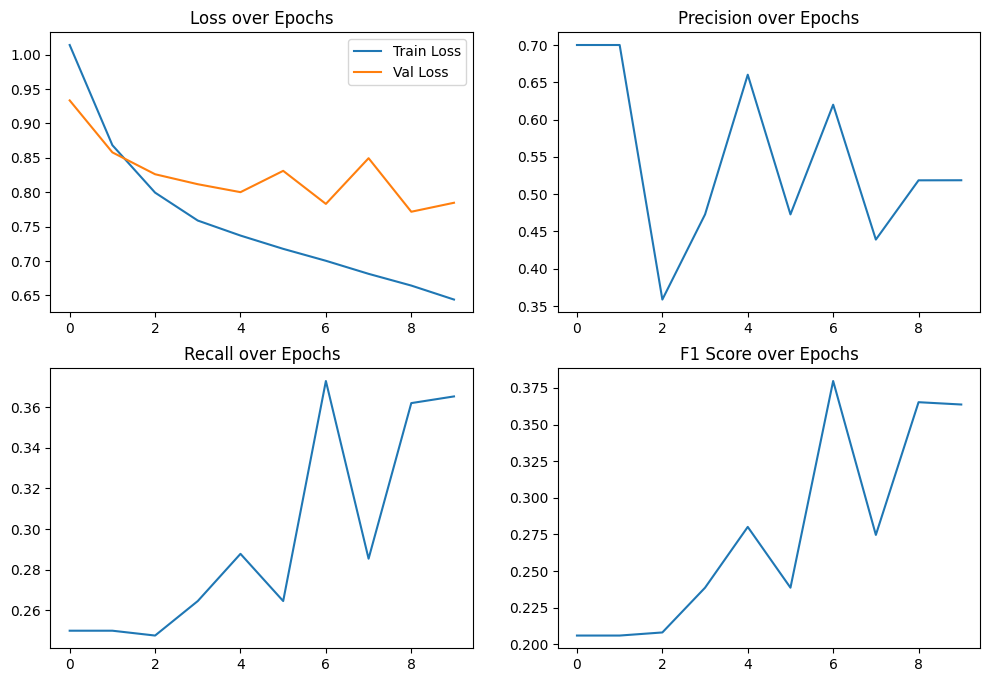

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(best_history['train_loss'], label='Train Loss')
plt.plot(best_history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(best_history['val_prec'], label='Val Precision')
plt.title('Precision over Epochs')

plt.subplot(2, 2, 3)
plt.plot(best_history['val_rec'], label='Val Recall')
plt.title('Recall over Epochs')

plt.subplot(2, 2, 4)
plt.plot(best_history['val_f1'], label='Val F1')
plt.title('F1 Score over Epochs')

plt.show()

Confusion matrix

In [ ]:
best_acc, best_prec, best_rec, best_f1, (all_labels, all_preds) = \
    eval_model(best_model, test_loader, device, return_ys=True)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1139: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(


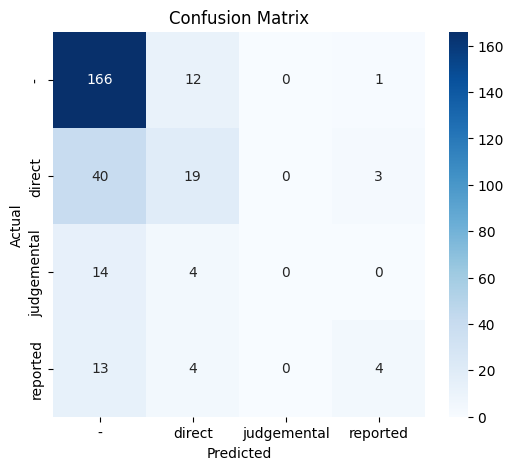

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['-', 'direct', 'judgemental', 'reported'],
            yticklabels=['-', 'direct', 'judgemental', 'reported'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig("imgs/cm-bilstm.png")
plt.show()

Precision-Recall curve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1139: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1139: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(


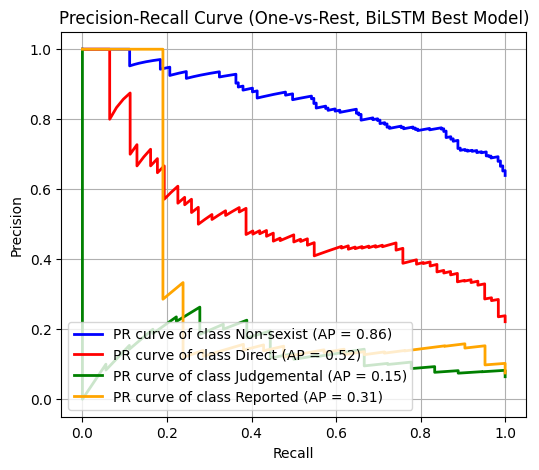

In [ ]:

# Get predictions and probabilities for the test set
best_acc, best_prec, best_rec, best_f1, (all_labels, all_preds) = eval_model(best_model, test_loader, device, return_ys=True)

# Get logits for each class
all_probs = []
best_model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)
        logits = best_model(inputs, lengths)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)
all_probs = np.concatenate(all_probs, axis=0)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(6,5))
colors = cycle(['blue', 'red', 'green', 'orange'])
class_labels = ['Non-sexist', 'Direct', 'Judgemental', 'Reported']

for i, color in zip(range(4), colors):
    binary_labels = (all_labels == i)
    precision, recall, _ = precision_recall_curve(binary_labels, all_probs[:, i])
    ap = average_precision_score(binary_labels, all_probs[:, i])
    plt.plot(recall, precision, color=color, lw=2,
             label=f'PR curve of class {class_labels[i]} (AP = {ap:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest, BiLSTM Best Model)")
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig("imgs/pr-bilstm.png")
plt.show()

ROC curve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1139: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(


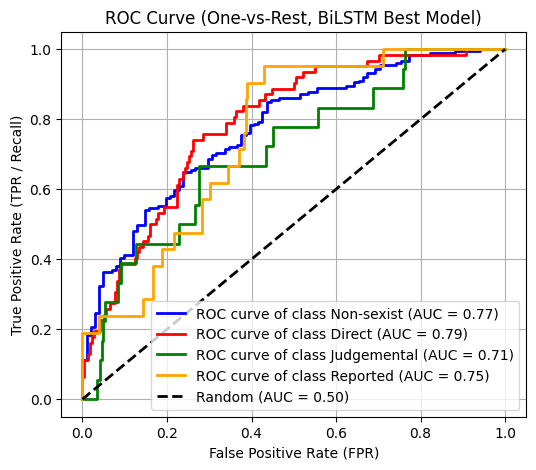

In [ ]:
# Get predictions and probabilities for the test set
best_model.eval()
all_probs = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)
        logits = best_model(inputs, lengths)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy())
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

plt.figure(figsize=(6,5))
colors = cycle(['blue', 'red', 'green', 'orange'])
class_labels = ['Non-sexist', 'Direct', 'Judgemental', 'Reported']

for i, color in zip(range(4), colors):
    binary_labels = (all_labels == i)
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR / Recall)")
plt.title("ROC Curve (One-vs-Rest, BiLSTM Best Model)")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("imgs/roc-bilstm.png")
plt.show()

##### Results on the actual data

In [ ]:
# Print some predictions with the best model
best_model.eval()
with torch.no_grad():
    for batch in val_loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        outputs = best_model(inputs, lengths)
        preds = outputs.argmax(dim=1).cpu().numpy()

        for i in range(inputs.size(0)):
            if labels[i].item() != 0:  # print only non-neutral tweets
                input_indices = inputs[i][:lengths[i]].cpu().numpy()
                input_words = [idx_to_word[idx] for idx in input_indices]
                print("Tweet:", " ".join(input_words))
                print("True label:", labels[i].item())
                print("Predicted label:", preds[i])
                print("")

Tweet: right push opposite direction convert female space <UNK> sex deny woman girl privacy safety male free area male behaviour problem female behaviour change must preserve boundary
True label: 3
Predicted label: 0

Tweet: man move <UNK> <UNK> <UNK> <UNK> train think good position completely reach rush train couple stop woman cant <UNK> <UNK> apparently
True label: 3
Predicted label: 0

Tweet: every second american sexually <UNK> read decide care survey find woman experience street harassment among woman sexually touch
True label: 3
Predicted label: 3

Tweet: sincerely wish u progressive womens right
True label: 2
Predicted label: 0

Tweet: need call day without woman woman amp ally usa <UNK> <UNK> <UNK>
True label: 1
Predicted label: 1

Tweet: day without woman would really economy
True label: 1
Predicted label: 0

Tweet: nearly student encounter sexual misconduct school
True label: 3
Predicted label: 0

Tweet: first scar stalking find <UNK> side realize sweet salty like good treat 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1139: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(


#### Training for different OOV strategies

A comparison of the impact of OOV stategy on the model training

In [ ]:
for strategy in ['random', 'context', 'mean', 'subwords', 'similarity']:
    print(f"\nOOV strategy: {strategy}")
    embedding_matrix = build_embedding_matrix(
        embedding_model=embedding_model,
        embedding_dimension=embedding_dimension,
        word_to_idx=word_to_idx,
        vocab_size=vocab_size,
        oov_terms=oov_terms,
        unk_token="<UNK>",
        oov_strategy=strategy,
    )

    best_model = None
    best_history = None
    criterion = nn.CrossEntropyLoss()
    training_report = {'stacked': []}
    best_f1 = 0

    for seed in seeds:
        stacked_model = BiLSTMClassifier(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, num_layers=2, freeze_embeddings=False)
        stacked_model.to(device)
        optimizer = optim.Adam(stacked_model.parameters(), lr=lr)
        stacked_model_history = train_loop(stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
        training_report['stacked'].append(eval_model(stacked_model, val_loader, device))
        if stacked_model_history['val_f1'][-1] > best_f1:
            best_f1 = stacked_model_history['val_f1'][-1]
            best_model = copy.deepcopy(stacked_model)
            best_history = stacked_model_history

    print("Best f1 score: ", best_f1)
    for idx, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
        stacked_scores = [run[idx] for run in training_report['stacked']]
        print(f"{metric} - Stacked: Mean = {np.mean(stacked_scores):.4f}, Std Dev = {np.std(stacked_scores):.4f}")


OOV strategy: random


Building embedding matrix: 100%|██████████| 9459/9459 [00:00<00:00, 302102.57it/s]


Best f1 score:  0.353335506301608
Accuracy - Stacked: Mean = 0.7022, Std Dev = 0.0083
Precision - Stacked: Mean = 0.4981, Std Dev = 0.0722
Recall - Stacked: Mean = 0.3250, Std Dev = 0.0128
F1 - Stacked: Mean = 0.3250, Std Dev = 0.0200

OOV strategy: context


Building embedding matrix: 100%|██████████| 9459/9459 [00:02<00:00, 3383.61it/s]


Best f1 score:  0.3712698813430952
Accuracy - Stacked: Mean = 0.7111, Std Dev = 0.0113
Precision - Stacked: Mean = 0.5042, Std Dev = 0.0352
Recall - Stacked: Mean = 0.3333, Std Dev = 0.0253
F1 - Stacked: Mean = 0.3352, Std Dev = 0.0294

OOV strategy: mean


Building embedding matrix: 100%|██████████| 9459/9459 [00:01<00:00, 5131.82it/s]


Best f1 score:  0.37805409245037724
Accuracy - Stacked: Mean = 0.7222, Std Dev = 0.0063
Precision - Stacked: Mean = 0.5306, Std Dev = 0.0334
Recall - Stacked: Mean = 0.3491, Std Dev = 0.0137
F1 - Stacked: Mean = 0.3545, Std Dev = 0.0173

OOV strategy: subwords


Building embedding matrix: 100%|██████████| 9459/9459 [00:00<00:00, 17773.80it/s]


Best f1 score:  0.34278115501519757
Accuracy - Stacked: Mean = 0.7111, Std Dev = 0.0063
Precision - Stacked: Mean = 0.4717, Std Dev = 0.0534
Recall - Stacked: Mean = 0.3182, Std Dev = 0.0191
F1 - Stacked: Mean = 0.3152, Std Dev = 0.0246

OOV strategy: similarity


Building embedding matrix: 100%|██████████| 9459/9459 [01:23<00:00, 113.03it/s]


Best f1 score:  0.35539627962202547
Accuracy - Stacked: Mean = 0.7089, Std Dev = 0.0063
Precision - Stacked: Mean = 0.4937, Std Dev = 0.0279
Recall - Stacked: Mean = 0.3297, Std Dev = 0.0161
F1 - Stacked: Mean = 0.3310, Std Dev = 0.0191


### BiGRU model

In [ ]:
# Baseline model definition
base_model = BiGRUClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=1)
base_model.to(device)
bi_stacked_model = BiGRUClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=2)
bi_stacked_model.to(device)
tri_stacked_model = BiGRUClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=3)
tri_stacked_model.to(device)

base_optimizer = optim.Adam(base_model.parameters(), lr=lr)
bi_stacked_optimizer = optim.Adam(bi_stacked_model.parameters(), lr=lr)
tri_stacked_optimizer = optim.Adam(tri_stacked_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Train and Evaluation
base_model_history = train_loop(base_model, num_epochs, train_loader, val_loader, base_optimizer, criterion, device, verbose=False)
base_report = eval_model(base_model, val_loader, device)
bi_stacked_model_history = train_loop(bi_stacked_model, num_epochs, train_loader, val_loader, bi_stacked_optimizer, criterion, device, verbose=False)
bi_stacked_report = eval_model(bi_stacked_model, val_loader, device)
tri_stacked_model_history = train_loop(tri_stacked_model, num_epochs, train_loader, val_loader, tri_stacked_optimizer, criterion, device, verbose=False)
tri_stacked_report = eval_model(tri_stacked_model, val_loader, device)

In [ ]:
print("Single layer training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(base_report[0], base_report[1], base_report[2], base_report[3]))
print("Bi-stacked layers training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(bi_stacked_report[0], bi_stacked_report[1], bi_stacked_report[2], bi_stacked_report[3]))
print("Tri-stacked layers training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(tri_stacked_report[0], tri_stacked_report[1], tri_stacked_report[2], tri_stacked_report[3]))

Single layer training: 
Accuracy: 0.7200, Precision: 0.5104, Recall: 0.3450, F1: 0.3494
Bi-stacked layers training: 
Accuracy: 0.7133, Precision: 0.5455, Recall: 0.3341, F1: 0.3420
Tri-stacked layers training: 
Accuracy: 0.7133, Precision: 0.5284, Recall: 0.3526, F1: 0.3583


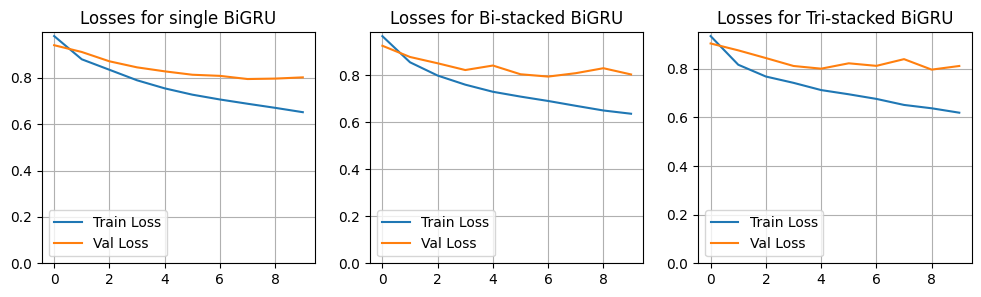

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(base_model_history['train_loss'], label='Train Loss')
plt.plot(base_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Losses for single BiGRU')
plt.grid()
plt.legend()
plt.subplot(1,3,2)
plt.plot(bi_stacked_model_history['train_loss'], label='Train Loss')
plt.plot(bi_stacked_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Losses for Bi-stacked BiGRU')
plt.grid()
plt.legend()
plt.subplot(1,3,3)
plt.plot(tri_stacked_model_history['train_loss'], label='Train Loss')
plt.plot(tri_stacked_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Losses for Tri-stacked BiGRU')
plt.grid()
plt.legend()
plt.show()

## Task 6 - Transformers

#### Model definition: roBERTa

In [ ]:
# We don't have to use the already preprocessed dataframes, because RoBERTa has its own preprocessing
train_data = Dataset.from_pandas(train_df_np)
val_data = Dataset.from_pandas(val_df_np)
test_data = Dataset.from_pandas(test_df_np)

In [ ]:
# visualize datasets
print(f"---- Train dataset visualization: ----\n {train_data}")
print(f"\n---- Test dataset visualization: ----\n {test_data}")


---- Train dataset visualization: ----
 Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__'],
    num_rows: 2873
})

---- Test dataset visualization: ----
 Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__'],
    num_rows: 280
})


In [ ]:
# define model_card and model tokenizer
task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
print(MODEL)

cardiffnlp/twitter-roberta-base-hate


#### Tokenizer definition

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
def show_differences(old_dataset, new_dataset, num_examples=3):
  """
  Displays random examples of differences between two datasets
  (before and after preprocessing) by comparing elements at the same index.

  Args:
    old_dataset: The original dataset.
    new_dataset: The preprocessed dataset.
    num_examples: The number of random examples to display.
  """
  if len(old_dataset) != len(new_dataset):
    raise ValueError("The two datasets must have the same length")

  for _ in range(0, num_examples):
    idx = np.random.randint(0, len(old_dataset))

    print("=====================")
    print(f"Random Example (Index {idx}):\n")
    print(f"Tweet before preprocessing: {old_dataset[idx]}")
    print(f"Tweet after preprocessing: {new_dataset[idx]}")


In [ ]:
# From Roberta-base-hate documentation
def preprocess_batch(batch):
    processed = []
    for text in batch["tweet"]:
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        processed.append(" ".join(new_text))
    batch["tweet"] = processed
    return batch

In [ ]:
old_train_tweets = train_data['tweet']
old_val_tweets = val_data['tweet']
old_test_tweets = test_data['tweet']

train_data = train_data.map(preprocess_batch, batched=True)
val_data = val_data.map(preprocess_batch, batched=True)
test_data = test_data.map(preprocess_batch, batched=True)

new_train_tweets = train_data['tweet']
new_val_tweets = val_data['tweet']
new_test_tweets = test_data['tweet']

show_differences(old_train_tweets, new_train_tweets)

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Random Example (Index 702):

Tweet before preprocessing: DUMB BLONDE (BLEACHED,but blonde) @kayleighmcenany taking over for the regular DUMB BLONDE  @ainsleyearhardt (aka Ainsley AIRHEAD), the regular on Fox &amp; Fiends tomorrow... https://t.co/Th664uHvyy https://t.co/a12F1tYRc0
Tweet after preprocessing: DUMB BLONDE (BLEACHED,but blonde) @user taking over for the regular DUMB BLONDE  @user (aka Ainsley AIRHEAD), the regular on Fox &amp; Fiends tomorrow... http http
Random Example (Index 2449):

Tweet before preprocessing: @QuackReportPod Almost unfollowed. Almost. Don’t touch my Ricky!!!!
Tweet after preprocessing: @user Almost unfollowed. Almost. Don’t touch my Ricky!!!!
Random Example (Index 2777):

Tweet before preprocessing: everytime i read womyn i get hysterical https://t.co/ndiZN5Uawv
Tweet after preprocessing: everytime i read womyn i get hysterical http


### Dataset Inspection

#### Preprocessing

In [ ]:
def preprocess_text_roBERTa(texts):
    return tokenizer(texts['tweet'], truncation=False)

train_data = train_data.map(preprocess_text_roBERTa, batched=True)
test_data = test_data.map(preprocess_text_roBERTa, batched=True)
val_data = val_data.map(preprocess_text_roBERTa, batched=True)

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
print(train_data)
print(test_data)

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2873
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 280
})


In [ ]:
# Show example
idx = np.random.randint(0, len(train_data))

print("Original tweet text:")
print(train_data['tweet'][idx][:200])

print("\nFirst 200 input IDs for a random example:")
print(train_data['input_ids'][idx][:200])

print("\nFirst 200 attention mask values:")
print(train_data['attention_mask'][idx][:200])


Original tweet text:
@user Loads of ass and tit, but unfortunately, like most women, no brain to go with it.

First 200 input IDs for a random example:
[0, 1039, 12105, 38355, 29, 9, 8446, 8, 13515, 6, 53, 9574, 6, 101, 144, 390, 6, 117, 2900, 7, 213, 19, 24, 4, 2]

First 200 attention mask values:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


#### Roberta special tokens

We have seen that 0 and 2 ids are the first and last tokens of the tweet

In [ ]:
for name, token in tokenizer.special_tokens_map.items():
    print(f"{name}: {token} -> id {tokenizer.convert_tokens_to_ids(token)}")

bos_token: <s> -> id 0
eos_token: </s> -> id 2
unk_token: <unk> -> id 3
sep_token: </s> -> id 2
pad_token: <pad> -> id 1
cls_token: <s> -> id 0
mask_token: <mask> -> id 50264


RoBERTa’s tokenizer works at the byte level and uses a special character, “Ġ”, to indicate that a token begins with a space. This is why we see tokens like “ĠGreat” or “Ġdata”: the “Ġ” simply marks that these words originally had a space before them.

In [ ]:
example_test = train_data['tweet'][idx]
encoded_example = tokenizer.encode_plus(example_test, add_special_tokens=False)
print(encoded_example.tokens())

['@', 'user', 'ĠLoad', 's', 'Ġof', 'Ġass', 'Ġand', 'Ġtit', ',', 'Ġbut', 'Ġunfortunately', ',', 'Ġlike', 'Ġmost', 'Ġwomen', ',', 'Ġno', 'Ġbrain', 'Ġto', 'Ġgo', 'Ġwith', 'Ġit', '.']


In [ ]:
def show_tokenization_examples(dataset, tokenizer, text_column="tweet", n=2, max_len=200):
    """
    Display original text and tokenizer-decoded text side by side for N random examples.

    Parameters:
      - dataset: Hugging Face Dataset (already tokenized)
      - tokenizer: Hugging Face tokenizer
      - text_column: name of the column containing the original text
      - n: number of random examples to display
      - max_len: maximum number of characters to print
    """
    total = len(dataset)
    indices = random.sample(range(total), n)

    for idx in indices:
        original_text = dataset[text_column][idx]
        input_ids = dataset['input_ids'][idx]
        decoded_text = tokenizer.decode(input_ids)

        print(f"=== Example {idx} ===")
        print("Original text:")
        print(original_text[:max_len])
        print("\nDecoded text from tokenizer:")
        print(decoded_text[:max_len])
        print("-" * 50)

In [ ]:
show_tokenization_examples(
    dataset=train_data,
    tokenizer=AutoTokenizer.from_pretrained(MODEL)
)

=== Example 1841 ===
Original text:
“The Los Angeles Raiders of Las Vegas” http

Decoded text from tokenizer:
<s>“The Los Angeles Raiders of Las Vegas” http</s>
--------------------------------------------------
=== Example 1928 ===
Original text:
@user Considering the last remake closed with the line "put her in the rape van." Im not at all optimistic.

Decoded text from tokenizer:
<s>@user Considering the last remake closed with the line "put her in the rape van." Im not at all optimistic.</s>
--------------------------------------------------


### Model creation and training

In [ ]:
# format input data to be fed as mini-batches: pad each tweet based on the longest tweet in the mini-batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Since RoBERTa was originally trained for 2 classes, but we want to predict 4 classes in our task, we need to set `ignore_mismatched_sizes=True` when loading the model. This way, the pre-trained weights are kept for all compatible layers, while the classification head is randomly initialized to match the new number of classes.


In [ ]:
num_labels = len(np.unique(train_df_np['label']))
id2label = {
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
label2id = {v:k for k,v in id2label.items()}


In [ ]:
# used only to show roberta architecture,
# but we will call this again, each time with different seed (for reproducibility)

config = AutoConfig.from_pretrained(
    MODEL,
    num_labels=4,
    id2label=id2label,
    label2id=label2id
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    config=config,
    ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# as we can see, now the out_features=4 for the last layer
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Metric Definition
We will use the metrics provided by HF.

In [ ]:
acc_metric = load('accuracy')
f1_metric = load('f1')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def compute_metrics_HF(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_metric.compute(predictions=predictions,
                           references=labels,
                           average="macro")

    acc = acc_metric.compute(predictions=predictions,
                             references=labels)

    return {"f1": f1["f1"], "accuracy": acc["accuracy"]}

In [ ]:
# use same hyperparam as BiRNN
batch_size = 16
num_epochs = 10

### Training Function

In [ ]:
def train_evaluate_over_seeds(
    seeds,
    model_name,
    base_training_args,
    train_data,
    val_data,
    test_data,
    tokenizer,
    data_collator,
    compute_metrics,
    id2label,
    label2id,
    fix_seed_fn,
    output_dir_root,
    csv_output_name,
    model_output_name
):
    """
    Runs the training loop over multiple seeds, saves the best model state based on
    Validation F1, and returns a DataFrame with aggregated results.
    """

    val_results, test_results = [], []
    best_val_f1 = -1
    best_model_state = None
    best_seed = None

    for seed in seeds:
        print(f"\n============================")
        print(f" Running with seed: {seed}")
        print(f"============================\n")

        # Set the seed (ensure fix_seed_fn is defined or passed correctly)
        fix_seed_fn(seed)

        # Deep copy arguments to avoid modifying the original object
        run_args = copy.deepcopy(base_training_args)
        run_args.output_dir = f"{output_dir_root}/seed_{seed}"

        # Model Configuration
        config = AutoConfig.from_pretrained(
            model_name,
            num_labels=len(id2label),
            id2label=id2label,
            label2id=label2id
        )

        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=config,
            ignore_mismatched_sizes=True
        )

        trainer = Trainer(
            model=model,
            args=run_args,
            train_dataset=train_data,
            eval_dataset=val_data,
            processing_class=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )

        trainer.train()

        # --- Evaluate on Validation set ---
        # we evaluate "again" the val set just in order to compute also the val loss (for the final comparison)
        val_metrics = trainer.evaluate(val_data)
        val_log_entry = {
            "seed": seed,
            "val_f1": val_metrics["eval_f1"],
            "val_loss": val_metrics["eval_loss"]
        }
        val_results.append(val_log_entry)

        print(f"Validation F1 for seed {seed}: {val_log_entry['val_f1']:.4f}")

        # Model selection based on val_f1
        # Of course, we select the best model based on validation performance
        if val_log_entry["val_f1"] > best_val_f1:
            print(f"New Best Model found (Seed {seed}) based on Val F1")
            best_val_f1 = val_log_entry["val_f1"]
            # Move state dict to CPU to save VRAM while the loop continues
            best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
            best_seed = seed

        # --- Evaluate on Test Set ---
        test_metrics = trainer.evaluate(test_data)
        test_log_entry = {
            "seed": seed,
            "test_f1": test_metrics["eval_f1"],
            "test_loss": test_metrics["eval_loss"]
        }
        test_results.append(test_log_entry)

        print(f"Test F1 for seed {seed}: {test_log_entry['test_f1']:.4f}")

        # --- MEMORY CLEANUP ---
        del model
        del trainer
        torch.cuda.empty_cache()
        gc.collect()

    # --- FINAL RESULTS AND REPORTING ---
    df_val = pd.DataFrame(val_results)
    df_test = pd.DataFrame(test_results)

    # Merge Validation and Test results
    df = pd.merge(df_val, df_test, on="seed")

    print("\n===== Results per Seed (Val & Test) =====")
    print(df)

    mean_f1 = df["test_f1"].mean()
    std_f1 = df["test_f1"].std()

    print("\n===== Aggregated Results =====")
    print(f"Mean F1 (on Test Set): {mean_f1:.4f}")
    print(f"Std Dev F1 (on Test Set): {std_f1:.4f}")

    print("\nBest seed (selected using Validation F1):", best_seed)
    print("Best F1 Validation Score:", best_val_f1)

    # Retrieve the test score associated with the best seed
    best_seed_test_f1 = df[df['seed'] == best_seed]['test_f1'].iloc[0]
    print(f"Test F1 associated with the best seed: {best_seed_test_f1:.4f}")

    # Save results to file
    df.to_csv(csv_output_name, index=False)
    if best_model_state is not None:
        torch.save(best_model_state, model_output_name)
        print(f"Best model saved to {model_output_name}")

    return best_model_state, best_seed

### Training Model - First Attempt with `lr = 1e-4`

In [ ]:
training_args_1e4 = TrainingArguments(
    output_dir="val_dir/trainer_1",             # where to save model
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,     # defines distributed training
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1 # RoBERTa benefits from a small warmup
)

In [ ]:
best_state, best_seed = train_evaluate_over_seeds(
    seeds=seeds,
    model_name=MODEL,
    base_training_args=training_args_1e4,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF,
    id2label=id2label,
    label2id=label2id,
    fix_seed_fn=fix_seed,
    output_dir_root="./results/lr_1e4",
    csv_output_name="roberta_seed_results_lr_1e4.csv",
    model_output_name="best_roberta_model_lr_1e4.pt"
)


 Running with seed: 42



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.821100,0.608879,0.390698,0.786667
2,0.659900,0.648239,0.468885,0.800000
3,0.524700,0.672175,0.460823,0.766667
4,0.388000,0.741379,0.485258,0.793333
5,0.290100,1.024092,0.490059,0.766667
6,0.210400,0.911100,0.512085,0.760000
7,0.107700,1.105444,0.564381,0.800000
8,0.055600,1.428743,0.499888,0.766667
9,0.027100,1.448642,0.558749,0.793333
10,0.010400,1.537001,0.558749,0.793333


Validation F1 for seed 42: 0.5644
New Best Model found (Seed 42) based on Val F1
Test F1 for seed 42: 0.4767

 Running with seed: 1337



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.776700,0.654198,0.420027,0.760000
2,0.677600,0.721001,0.460468,0.773333
3,0.528300,0.553475,0.584347,0.846667
4,0.382600,0.648305,0.475877,0.793333
5,0.270200,0.857540,0.502035,0.793333
6,0.203700,0.957231,0.514173,0.806667


Validation F1 for seed 1337: 0.5843
New Best Model found (Seed 1337) based on Val F1
Test F1 for seed 1337: 0.4544

 Running with seed: 2025



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.793200,0.631485,0.465202,0.780000
2,0.668800,0.635409,0.439484,0.760000
3,0.521200,0.554333,0.501852,0.793333
4,0.363100,0.835782,0.575499,0.800000
5,0.263300,0.887117,0.523051,0.806667
6,0.208200,1.112988,0.452795,0.766667
7,0.142100,1.150236,0.613296,0.780000
8,0.072000,1.183830,0.594225,0.806667
9,0.035000,1.319818,0.579977,0.793333
10,0.022200,1.298998,0.590282,0.800000


Validation F1 for seed 2025: 0.6133
New Best Model found (Seed 2025) based on Val F1
Test F1 for seed 2025: 0.5015

===== Results per Seed (Val & Test) =====
   seed    val_f1  val_loss   test_f1  test_loss
0    42  0.564381  1.105444  0.476669   1.573898
1  1337  0.584347  0.553475  0.454440   0.781529
2  2025  0.613296  1.150236  0.501500   1.558882

===== Aggregated Results =====
Mean F1 (on Test Set): 0.4775
Std Dev F1 (on Test Set): 0.0235

Best seed (selected using Validation F1): 2025
Best F1 Validation Score: 0.6132962930299556
Test F1 associated with the best seed: 0.5015
Best model saved to best_roberta_model_lr_1e4.pt


### Training Model - Second Attempt with `lr = 2e-5`
Let's try with the standard lr for RoBERTa, i.e. `lr = 2e-5`

In [ ]:
model_2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    config=config,
    ignore_mismatched_sizes=True
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# try with lr=2e-5

training_args_lr2e5 = TrainingArguments(
    output_dir="val_dir/trainer_2",             # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,     # defines distributed training
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1 # RoBERTa benefits from a small warmup
)

In [ ]:
best_state, best_seed = train_evaluate_over_seeds(
    seeds=seeds,
    model_name=MODEL,
    base_training_args=training_args_lr2e5,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF,
    id2label=id2label,
    label2id=label2id,
    fix_seed_fn=fix_seed,
    output_dir_root="./results/lr_2e5",
    csv_output_name="roberta_seed_results_lr_2e5.csv",
    model_output_name="best_roberta_model_lr2e5.pt"
)


 Running with seed: 42



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.893800,0.605745,0.430792,0.800000
2,0.577300,0.586115,0.514488,0.806667
3,0.423200,0.598822,0.578601,0.806667
4,0.293700,0.764039,0.562987,0.780000
5,0.193900,0.855820,0.583069,0.786667
6,0.125600,0.983661,0.608026,0.773333
7,0.080500,1.156701,0.544245,0.773333
8,0.050700,1.237162,0.555939,0.786667
9,0.030900,1.303821,0.524966,0.773333


Validation F1 for seed 42: 0.6080
New Best Model found (Seed 42) based on Val F1
Test F1 for seed 42: 0.5305

 Running with seed: 1337



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.800900,0.609208,0.381532,0.786667
2,0.579700,0.593304,0.507606,0.806667
3,0.428100,0.610492,0.587102,0.813333
4,0.288600,0.755484,0.536712,0.786667
5,0.188700,0.908978,0.541318,0.786667
6,0.133200,1.013416,0.515775,0.760000


Validation F1 for seed 1337: 0.5871
Test F1 for seed 1337: 0.4791

 Running with seed: 2025



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.850300,0.597631,0.431586,0.800000
2,0.575900,0.563150,0.511166,0.806667
3,0.412100,0.609315,0.557874,0.820000
4,0.281200,0.773597,0.486899,0.786667
5,0.184200,0.879404,0.572685,0.806667
6,0.138900,1.024735,0.516898,0.773333
7,0.092700,1.144104,0.521286,0.766667
8,0.058000,1.213634,0.529747,0.786667


Validation F1 for seed 2025: 0.5727
Test F1 for seed 2025: 0.4944

===== Results per Seed (Val & Test) =====
   seed    val_f1  val_loss  test_f1  test_loss
0    42  0.608026  0.983661  0.53051   1.370695
1  1337  0.587102  0.610492  0.47909   0.764966
2  2025  0.572685  0.879404  0.49442   1.156585

===== Aggregated Results =====
Mean F1 (on Test Set): 0.5013
Std Dev F1 (on Test Set): 0.0264

Best seed (selected using Validation F1): 42
Best F1 Validation Score: 0.6080262555872311
Test F1 associated with the best seed: 0.5305
Best model saved to best_roberta_model_lr2e5.pt


As we can see, by selecting an appropriate learning rate, our F1-score on the test set increased from $0.50$ to $0.53$!

### Results
We are going to use the last model, i.e. the best performing one.

In [ ]:
fix_seed(best_seed)

#### Show predictions

In [ ]:
config = AutoConfig.from_pretrained(
        MODEL, num_labels=4, id2label=id2label, label2id=label2id
    )

best_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, config=config, ignore_mismatched_sizes=True
)

best_model.load_state_dict(best_state)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
# define model for inference
prediction_args = TrainingArguments(
    output_dir="./prediction_output",
    per_device_eval_batch_size=batch_size,
    eval_strategy="no",
    save_strategy="no",
    report_to='none',
)

inference_trainer = Trainer(
    model=best_model,
    args=prediction_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF
)

In [ ]:
def predict_and_sample(
    trainer,
    test_data,
    tokenizer,
    id2label=None,
    num_samples=10,
    ignore_class_id=0
):
    """
    Runs predictions on the test set, decodes the text, and prints random samples
    comparing Ground Truth vs Prediction.

    Args:
        trainer: The Hugging Face Trainer object (already trained or with loaded weights).
        test_data: The dataset to predict on.
        tokenizer: The tokenizer used for decoding input_ids.
        id2label: Dictionary mapping IDs to label names.
        num_samples: How many examples to print.
        ignore_class_id: The class ID to skip (e.g., 0 for neutral) to focus on interesting cases.

    Returns:
        preds: The array of predicted class IDs.
        labels: The array of true class IDs.
    """

    print("Running predictions on test set...")

    predictions_output = trainer.predict(test_data)

    logits = predictions_output.predictions
    labels = predictions_output.label_ids

    # Convert logits to probabilities using torch.softmax
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    # Get predictions (0, 1, 2, 3)
    preds = np.argmax(logits, axis=-1)


    # Decode the original tweets
    decoded_texts = tokenizer.batch_decode(test_data['input_ids'], skip_special_tokens=True)

    print(f"\n=== Prediction vs Ground Truth labels (Excluding Class {ignore_class_id}) ===\n")

    interesting_indices = [i for i, label in enumerate(labels) if label != ignore_class_id]

    if not interesting_indices:
        print(f"No examples found with label != {ignore_class_id}.")
        return preds, labels

    # Select random samples
    # If we have fewer examples than requested, just show all of them
    actual_sample_count = min(num_samples, len(interesting_indices))
    selected_indices = random.sample(interesting_indices, actual_sample_count)

    for idx in selected_indices:
        print(f"Tweet: {decoded_texts[idx]}")

        # Use .get() to avoid errors if a label is missing from the map
        true_lbl_name = id2label.get(labels[idx], str(labels[idx]))
        pred_lbl_name = id2label.get(preds[idx], str(preds[idx]))

        print(f"True label:      {true_lbl_name} ({labels[idx]})")
        print(f"Predicted label: {pred_lbl_name} ({preds[idx]})")

        result = "CORRECT" if labels[idx] == preds[idx] else "WRONG"
        print(f"Result: {result}")
        print("-" * 50)

    return preds, labels, probs

In [ ]:
preds, true_labels, probs = predict_and_sample(
    trainer=inference_trainer,
    test_data=test_data,
    tokenizer=tokenizer,
    id2label=id2label,
    num_samples=10,
    ignore_class_id=0  # Skips class 0 (Neutral)
)

Running predictions on test set...



=== Prediction vs Ground Truth labels (Excluding Class 0) ===

Tweet: My handmaiden relatives, alums of @user are posting claptrap on FB. These young women don't know how to drive, have never worked, are subservient to their "headships," and endanger their children in homes filled with AR-15s. Because Jesus, y'all. http
True label:      1 (1)
Predicted label: 3 (3)
Result: WRONG
--------------------------------------------------
Tweet: "I am not like other queers I hate women" misogynist and proud http
True label:      1 (1)
Predicted label: 1 (1)
Result: CORRECT
--------------------------------------------------
Tweet: @user Maybe something involving her getting gangbanged~?
True label:      1 (1)
Predicted label: 1 (1)
Result: CORRECT
--------------------------------------------------
Tweet: This genration are no more then selfish cunts. More matter how genuine you are, you do all the right things and  they still make you look like a cunt. It’s only getting worse too, and people ask

#### Confusion Matrix

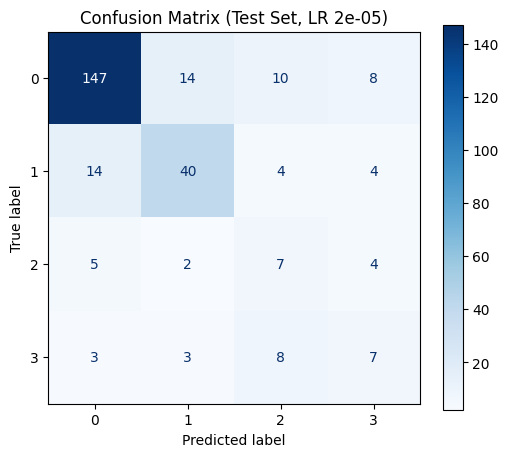

In [ ]:
def display_confusion_matrix(labels, preds):
  cm = confusion_matrix(y_true=labels, y_pred=preds)

  class_labels = list(id2label.values())
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

  fig, ax = plt.subplots(figsize=(6,5))
  disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')

  ax.set_title(f'Confusion Matrix (Test Set, LR {training_args_lr2e5.learning_rate})')
  plt.savefig("imgs/cm-trans.png")
  plt.show()

display_confusion_matrix(true_labels, preds)

#### Plots

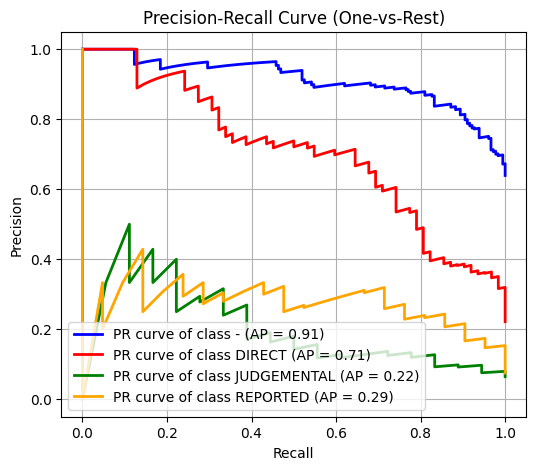

In [ ]:
def pr_curve(labels, probabilities):
  plt.figure(figsize=(6,5))
  colors = cycle(['blue', 'red', 'green', 'orange'])
  class_labels = ['-', 'DIRECT', 'JUDGEMENTAL', 'REPORTED']

  for i, color in zip(range(4), colors):
      binary_labels = (labels == i)
      precision, recall, _ = precision_recall_curve(binary_labels, probabilities[:, i])

      ap = average_precision_score(binary_labels, probabilities[:, i])

      plt.plot(recall, precision, color=color, lw=2,
              label=f'PR curve of class {class_labels[i]} (AP = {ap:.2f})')

  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Precision-Recall Curve (One-vs-Rest)")
  plt.legend(loc="lower left")
  plt.grid(True)
  plt.savefig("imgs/pr-trans.png")
  plt.show()

pr_curve(true_labels, probs)

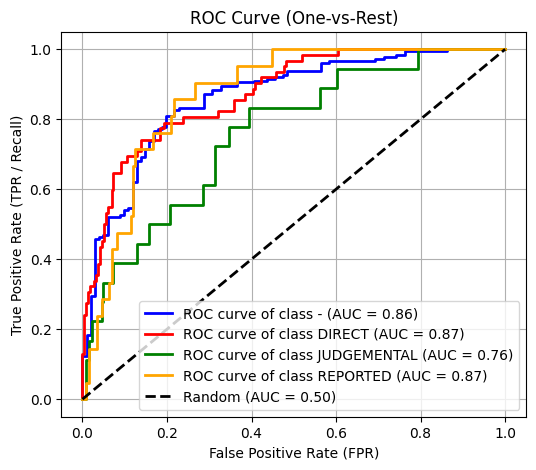

In [ ]:
def plot_roc_curve(labels, probabilities):
  plt.figure(figsize=(6,5))
  colors = cycle(['blue', 'red', 'green', 'orange'])
  class_labels = ['-', 'DIRECT', 'JUDGEMENTAL', 'REPORTED']

  for i, color in zip(range(4), colors):
      binary_labels = (labels == i)

      # Compute True Positive Rate (TPR) and False Positive Rate (FPR)
      fpr, tpr, _ = roc_curve(binary_labels, probabilities[:, i])

      # Compute Area Under Curve
      roc_auc = auc(fpr, tpr)

      plt.plot(fpr, tpr, color=color, lw=2,
              label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc:.2f})')

  # Random classifier plot (AUC = 0.5)
  plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')

  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR / Recall)")
  plt.title("ROC Curve (One-vs-Rest)")
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.savefig("imgs/roc-trans.png")
  plt.show()

plot_roc_curve(true_labels, probs)

### Try different model: DeBERTa-v3-small

Made by Microsoft

#### Load model

In [ ]:
MODEL = "microsoft/deberta-v3-base"

print(f"Loading: {MODEL}")


Loading: microsoft/deberta-v3-base


#### Load tokenizer and preprocessing

In [ ]:
tokenizer_deBERTa = AutoTokenizer.from_pretrained(MODEL)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
def preprocess_text_deBERTa(texts):
    return tokenizer_deBERTa(texts['tweet'], truncation=False)

train_data = train_data.map(preprocess_text_deBERTa, batched=True)
test_data = test_data.map(preprocess_text_deBERTa, batched=True)
val_data = val_data.map(preprocess_text_deBERTa, batched=True)

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
for name, token in tokenizer.special_tokens_map.items():
    print(f"{name}: {token} -> id {tokenizer_deBERTa.convert_tokens_to_ids(token)}")

bos_token: <s> -> id 3
eos_token: </s> -> id 3
unk_token: <unk> -> id 3
sep_token: </s> -> id 3
pad_token: <pad> -> id 3
cls_token: <s> -> id 3
mask_token: <mask> -> id 3


In [ ]:
show_tokenization_examples(
    dataset=train_data,
    tokenizer=AutoTokenizer.from_pretrained(MODEL)
)

=== Example 2233 ===
Original text:
@user Those who release the BH members into society, deserve what?@Jidekoro

Decoded text from tokenizer:
[CLS] @user Those who release the BH members into society, deserve what?@Jidekoro[SEP]
--------------------------------------------------
=== Example 356 ===
Original text:
Ok, its normal for people to overshare things when you don’t feel heard half of the time, so when someone finally asks you a question you can’t help but talk talk talk hoping someone would finally hea

Decoded text from tokenizer:
[CLS] Ok, its normal for people to overshare things when you don’t feel heard half of the time, so when someone finally asks you a question you can’t help but talk talk talk hoping someone would final
--------------------------------------------------


#### Create model

In [ ]:
# format input data to be fed as mini-batches: pad each tweet based on the longest tweet in the mini-batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


config = AutoConfig.from_pretrained(
    MODEL,
    num_labels=4,
    id2label=id2label,
    label2id=label2id
)

model_deberta = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    config=config,
    ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model_deberta)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

#### Train model

In [ ]:
# try with lr=2e-5

training_args_deberta_lr2e5 = TrainingArguments(
    output_dir="val_dir/trainer_deberta",             # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,     # defines distributed training
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1
)

In [ ]:
best_state_deberta, best_seed_deberta = train_evaluate_over_seeds(
    seeds=seeds,
    model_name=MODEL,
    base_training_args=training_args_deberta_lr2e5,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    tokenizer=tokenizer_deBERTa,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF,
    id2label=id2label,
    label2id=label2id,
    fix_seed_fn=fix_seed,
    output_dir_root="./results/deberta_lr_2e5",
    csv_output_name="deberta_seed_results_lr_2e5.csv",
    model_output_name="best_deberta_model_lr2e5.pt"
)


 Running with seed: 42



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.016700,0.692693,0.317763,0.733333
2,0.666200,0.648681,0.482012,0.760000
3,0.543600,0.579525,0.524492,0.793333
4,0.429900,0.634915,0.546819,0.793333
5,0.342400,0.653519,0.530640,0.806667
6,0.258000,0.757642,0.553647,0.786667
7,0.196000,0.848729,0.543100,0.773333
8,0.149600,0.975560,0.526584,0.773333
9,0.114900,1.048685,0.575176,0.793333
10,0.094900,1.087495,0.561794,0.780000


Validation F1 for seed 42: 0.5752
New Best Model found (Seed 42) based on Val F1
Test F1 for seed 42: 0.4474

 Running with seed: 1337



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.952500,0.731524,0.324946,0.740000
2,0.688700,0.615180,0.325531,0.706667
3,0.546700,0.547886,0.509151,0.800000
4,0.446300,0.597900,0.513126,0.780000
5,0.362000,0.667148,0.476484,0.780000
6,0.257700,0.635889,0.633571,0.820000
7,0.186700,0.822927,0.630284,0.806667
8,0.144800,0.961491,0.522195,0.766667
9,0.100800,1.102024,0.549476,0.773333


Validation F1 for seed 1337: 0.6336
New Best Model found (Seed 1337) based on Val F1
Test F1 for seed 1337: 0.4714

 Running with seed: 2025



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.974100,0.726594,0.244208,0.706667
2,0.660500,0.629456,0.457636,0.760000
3,0.552100,0.626350,0.450948,0.740000
4,0.455400,0.573831,0.527903,0.826667
5,0.356100,0.728563,0.505208,0.800000
6,0.273300,0.672170,0.648296,0.833333
7,0.209900,0.724010,0.605283,0.800000
8,0.153400,0.876711,0.645314,0.820000
9,0.124900,0.909245,0.660390,0.820000
10,0.094500,0.926291,0.662450,0.820000


Validation F1 for seed 2025: 0.6625
New Best Model found (Seed 2025) based on Val F1
Test F1 for seed 2025: 0.5021

===== Results per Seed (Val & Test) =====
   seed    val_f1  val_loss   test_f1  test_loss
0    42  0.575176  1.048685  0.447426   1.482887
1  1337  0.633571  0.635889  0.471375   1.064111
2  2025  0.662450  0.926291  0.502100   1.462599

===== Aggregated Results =====
Mean F1 (on Test Set): 0.4736
Std Dev F1 (on Test Set): 0.0274

Best seed (selected using Validation F1): 2025
Best F1 Validation Score: 0.662450082217524
Test F1 associated with the best seed: 0.5021
Best model saved to best_deberta_model_lr2e5.pt


As we can notice, even a strong model as deBERTa-v3 (in the small version) doesn't perform as good as a roBERTa in its hate-speech detection fine-tuned version.

## Task 7 - Error Analysis

### Task 3 - 5

All of the recorded F1 scores are lower that `0.55`, as the dataset is small and highly imbalanced.  
Furthermore, both the BiLSTM model and the transformer-based model make similar mistakes.

### Baseline classifier

Before starting the error analysis it is helpful to have a baseline to compare our models to.  
We will build a simple SVM classifier for this purpose.


In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(train_df['tweet'])
X_test_tfidf = vectorizer.transform(test_df['tweet'])
y_train = train_df['label'].values
y_test = test_df['label'].values
svm_classifier = SVC(kernel='linear', random_state=seeds[0])
svm_classifier.fit(X_train_tfidf, y_train)
y_test_pred = svm_classifier.predict(X_test_tfidf)

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print("SVM Classifier Evaluation on Test Set:")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(accuracy, precision, recall, f1))

SVM Classifier Evaluation on Test Set:
Accuracy: 0.6857, Precision: 0.4141, Recall: 0.3314, F1: 0.3289


#### Plots

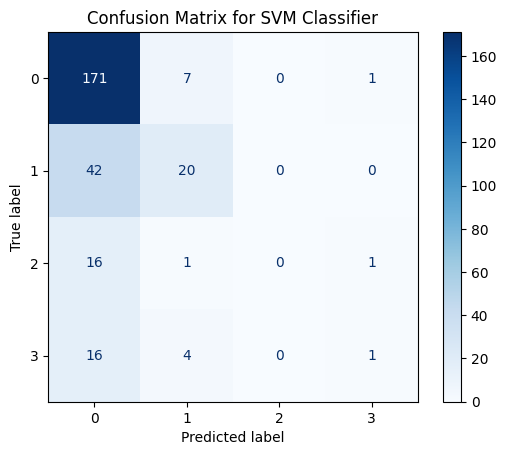

In [ ]:
ConfusionMatrixDisplay.from_estimator(svm_classifier, X_test_tfidf, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM Classifier')
plt.savefig("imgs/cm-svm.png")
plt.show()

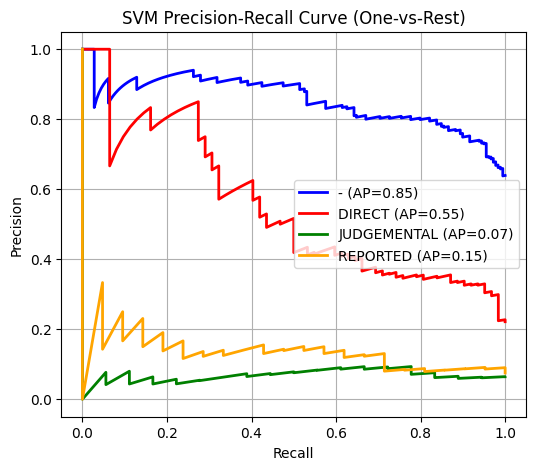

In [ ]:
# get continuous scores (decision_function or predict_proba)
if hasattr(svm_classifier, "decision_function"):
    scores = svm_classifier.decision_function(X_test_tfidf)  # shape (n_samples, n_classes) for multiclass
else:
    scores = svm_classifier.predict_proba(X_test_tfidf)

# binarize true labels for one-vs-rest PR curves
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])

plt.figure(figsize=(6,5))
colors = ['blue', 'red', 'green', 'orange']
class_names = ['-', 'DIRECT', 'JUDGEMENTAL', 'REPORTED']

for i, color in enumerate(colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], scores[:, i])
    ap = average_precision_score(y_test_bin[:, i], scores[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f'{class_names[i]} (AP={ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc='center right')
plt.grid(True)
plt.savefig("imgs/pr-svm.png")
plt.show()

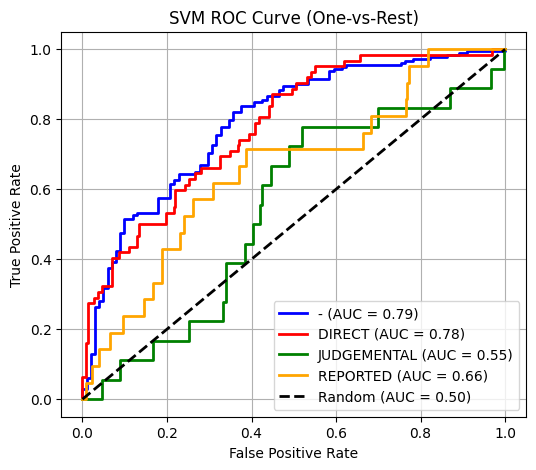

In [ ]:
plt.figure(figsize=(6,5))
colors = ['blue', 'red', 'green', 'orange']
class_names = ['-', 'DIRECT', 'JUDGEMENTAL', 'REPORTED']

for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("imgs/roc-svm.png")
plt.show()

### Models Comparison

**Confusion Matrices** (SVM, BiLSTM, RoBERTa)

<img src="imgs/cm-svm.png" style="width:33%;">
<img src="imgs/cm-bilstm.png" style="width:33%;">
<img src="imgs/cm-trans.png" style="width:33%;">


**Precision-Recall curves** (SVM, BiLSTM, RoBERTa)

<img src="imgs/pr-svm.png" style="width:33%;">
<img src="imgs/pr-bilstm.png" style="width:33%;">
<img src="imgs/pr-trans.png" style="width:33%;">

**ROC curves** (SVM, BiLSTM, RoBERTa)

<img src="imgs/roc-svm.png" style="width:33%;">
<img src="imgs/roc-bilstm.png" style="width:33%;">
<img src="imgs/roc-trans.png" style="width:33%;">


We can asses our results from the plots:
- the **transformer-based** model is the best classifer, performing best on all metrics for the majority and minority classes
- the **BiLSTM** is slightly better than the baseline, especially for the minority classes
- the **SVM** classifier predictions are heavily skewed towards the unbalanced class, leading to it identifying the highest number of non-sexist tweets but the lowest for the other classes

### BiLSTM Improvement - Dataset balancing

In [ ]:
from sklearn.utils import resample

def oversample_multiclass(df, target_col='label', random_state=101):
    """Balance a multi-class dataset by oversampling minority classes."""
    max_size = df[target_col].value_counts().max()

    oversampled_parts = [
        resample(df[df[target_col] == label],
                 replace=True,
                 n_samples=max_size,
                 random_state=random_state)
        for label in df[target_col].unique()
    ]

    df_oversampled = pd.concat(oversampled_parts)
    return df_oversampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

oversampled_train_df_np = oversample_multiclass(train_df_np)
oversampled_val_df_np = oversample_multiclass(val_df_np)
oversampled_test_df_np = oversample_multiclass(test_df_np)

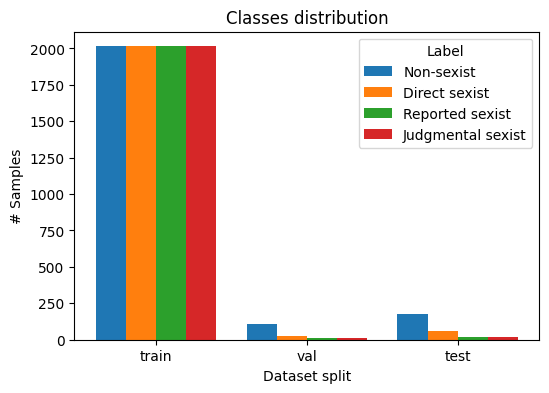

In [ ]:
oversampled_inspection_df = pd.DataFrame()
oversampled_inspection_df = pd.concat([oversampled_train_df_np, val_df_np, test_df_np], ignore_index=True)

# set the set attribute to train, val or test
oversampled_inspection_df['split'] = ''
oversampled_inspection_df.loc[:len(oversampled_train_df_np)-1, 'split'] = 'train'
oversampled_inspection_df.loc[len(oversampled_train_df_np):len(oversampled_train_df_np)+len(val_df_np)-1, 'split'] = 'val'
oversampled_inspection_df.loc[len(oversampled_train_df_np)+len(val_df_np):, 'split'] = 'test'
labels = ['Non-sexist', 'Direct sexist', 'Reported sexist', 'Judgmental sexist']
splits = ['train', 'val', 'test']
counts = {
    label: [
        np.sum((oversampled_inspection_df.split == split) & (oversampled_inspection_df.label == i))
        for split in splits
    ]
    for i, label in enumerate(labels)
}
x = np.arange(len(splits))
width = 0.2
plt.figure(figsize=(6,4))
for i, label in enumerate(labels):
    plt.bar(x + i * width, counts[label], width, label=label)
plt.xticks(x + width * 1.5, splits)
plt.xlabel('Dataset split')
plt.ylabel('# Samples')
plt.title('Classes distribution')
plt.legend(title='Label')
plt.show()

In [ ]:
pipeline = [clean_text, lemmatize_text]
oversampled_train_df = text_preprocessing(oversampled_train_df_np, pipeline=pipeline)
val_df = text_preprocessing(val_df_np, pipeline=pipeline)
test_df = text_preprocessing(test_df_np, pipeline=pipeline)

In [ ]:
oversampled_idx_to_word, oversampled_word_to_idx, oversampled_word_listing, oversampled_vocab_df = build_vocabulary(oversampled_train_df)
oversampled_vocab_size = len(oversampled_word_to_idx)
oversampled_embedding_matrix = build_embedding_matrix(
    embedding_model=embedding_model,
    embedding_dimension=embedding_dimension,
    word_to_idx=oversampled_word_to_idx,
    vocab_size=oversampled_vocab_size,
    oov_terms=oov_terms,
    unk_token="<UNK>",
    oov_strategy="subwords",
)

Building embedding matrix: 100%|██████████| 7575/7575 [00:00<00:00, 21824.07it/s]


In [ ]:
oversampled_train_loader = DataLoader(TweetDataset(oversampled_train_df, oversampled_word_to_idx), batch_size=batch_size,
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TweetDataset(val_df, oversampled_word_to_idx), batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(TweetDataset(test_df, oversampled_word_to_idx), batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)

In [ ]:
oversampled_best_model = None
oversampled_best_history = None
criterion = nn.CrossEntropyLoss()
oversampled_training_report = {'baseline': [], 'stacked': []}
oversampled_best_f1 = 0

for seed in seeds:  # try 3 different random seeds
    print(f"\nRandom seed: {seed}")
    fix_seed(seed)
    oversampled_baseline_model = BiLSTMClassifier(embedding_matrix=oversampled_embedding_matrix, hidden_dim=hidden_dim, num_layers=1)
    oversampled_baseline_model.to(device)
    optimizer = optim.Adam(oversampled_baseline_model.parameters(), lr=lr)
    oversampled_baseline_model_history = train_loop(oversampled_baseline_model, num_epochs, oversampled_train_loader, val_loader, optimizer, criterion, device, verbose=False)
    oversampled_training_report['baseline'].append(eval_model(oversampled_baseline_model, test_loader, device))
    print("Baseline training: ")
    print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(oversampled_training_report['baseline'][-1][0], oversampled_training_report['baseline'][-1][1], oversampled_training_report['baseline'][-1][2], oversampled_training_report['baseline'][-1][3]))
    if oversampled_baseline_model_history['val_f1'][-1] > oversampled_best_f1:
        best_f1 = oversampled_baseline_model_history['val_f1'][-1]
        oversampled_best_model = copy.deepcopy(oversampled_baseline_model)
        oversampled_best_history = oversampled_baseline_model_history

    oversampled_stacked_model = BiLSTMClassifier(embedding_matrix=oversampled_embedding_matrix, hidden_dim=hidden_dim, num_layers=2)
    oversampled_stacked_model.to(device)
    optimizer = optim.Adam(oversampled_stacked_model.parameters(), lr=lr)
    oversampled_stacked_model_history = train_loop(oversampled_stacked_model, num_epochs, oversampled_train_loader, val_loader, optimizer, criterion, device, verbose=False)
    oversampled_training_report['stacked'].append(eval_model(oversampled_stacked_model, test_loader, device))
    print("Stacked training: ")
    print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(oversampled_training_report['stacked'][-1][0], oversampled_training_report['stacked'][-1][1], oversampled_training_report['stacked'][-1][2], oversampled_training_report['stacked'][-1][3]))
    if oversampled_stacked_model_history['val_f1'][-1] > oversampled_best_f1:
        oversampled_best_f1 = oversampled_stacked_model_history['val_f1'][-1]
        oversampled_best_model = copy.deepcopy(oversampled_stacked_model)
        oversampled_best_history = oversampled_stacked_model_history

print("----------------------------")

for idx, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    baseline_scores = [run[idx] for run in oversampled_training_report['baseline']]
    stacked_scores = [run[idx] for run in oversampled_training_report['stacked']]
    print(f"{metric} - Baseline: Mean = {np.mean(baseline_scores):.4f}, Std Dev = {np.std(baseline_scores):.4f} | Stacked: Mean = {np.mean(stacked_scores):.4f}, Std Dev = {np.std(stacked_scores):.4f}")


Random seed: 42
Baseline training: 
Accuracy: 0.6393, Precision: 0.4369, Recall: 0.4145, F1: 0.4178
Stacked training: 
Accuracy: 0.6179, Precision: 0.3914, Recall: 0.3989, F1: 0.3932

Random seed: 1337
Baseline training: 
Accuracy: 0.5929, Precision: 0.4040, Recall: 0.4383, F1: 0.4070
Stacked training: 
Accuracy: 0.5893, Precision: 0.3622, Recall: 0.3857, F1: 0.3718

Random seed: 2025
Baseline training: 
Accuracy: 0.6143, Precision: 0.3633, Recall: 0.3929, F1: 0.3748
Stacked training: 
Accuracy: 0.6036, Precision: 0.3972, Recall: 0.3901, F1: 0.3844
----------------------------
Accuracy - Baseline: Mean = 0.6155, Std Dev = 0.0190 | Stacked: Mean = 0.6036, Std Dev = 0.0117
Precision - Baseline: Mean = 0.4014, Std Dev = 0.0301 | Stacked: Mean = 0.3836, Std Dev = 0.0153
Recall - Baseline: Mean = 0.4152, Std Dev = 0.0186 | Stacked: Mean = 0.3916, Std Dev = 0.0055
F1 - Baseline: Mean = 0.3999, Std Dev = 0.0183 | Stacked: Mean = 0.3831, Std Dev = 0.0088


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1139: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(


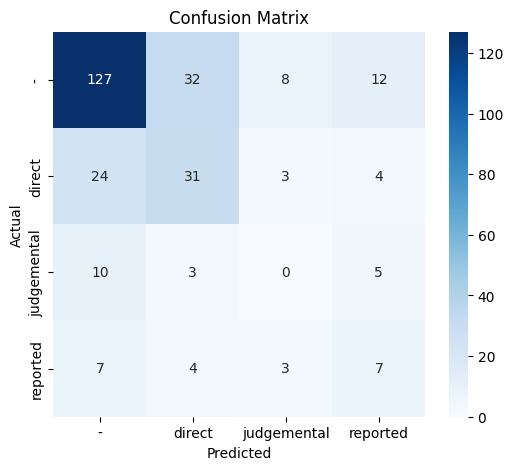

In [ ]:
_, _, _, _, (oversampled_all_labels, oversampled_all_preds) = \
    eval_model(oversampled_best_model, test_loader, device, return_ys=True)

cm = confusion_matrix(oversampled_all_labels, oversampled_all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['-', 'direct', 'judgemental', 'reported'],
            yticklabels=['-', 'direct', 'judgemental', 'reported'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig("imgs/cm-bilstm.png")
plt.show()

#### Considerations
The balancing led to marginal improvements, especially for the baseline model, but the F1-score is still quite low.  
This suggest that the imbalanced dataset is only part of the problem, and that some classes are inherently harder to learn than others.

Analyzing the Confusion matrix we can see that many of the direct samples are predicted as - (non sexist). These two labels should be the most far apart, and this behaviour indicates that the model didn't find a reliable way to classify the tweets.

### RoBERTa improvement - Dataset balancing


The same considerations previosuly written for the BiLSTM model yield also for RoBERTa perfomances.
Indeed, as we can clearly see from the Precision-Recall (PR) Curve and the ROC Curve, the model **excels** at correctly classifying `neutral` and `direct` tweets.

On the other hand, the model demonstrates severe struggle with `judgemental` tweets and performs truly poorly when attempting to classify `reported` tweets.

As we have said, this behavior is not surprising, as the dataset is heavily imbalanced, skewing towards the `neutral` class.

**Detailed Analysis of Poorly Performing Classes:**

* **`Reported` tweets:** The combination of a low Average Precision ($\text{AP}=0.29$) and a relatively high Area Under the Curve ($\text{AUC}=0.87$) suggests a classic case of **extreme class imbalance**. The high AUC indicates the model is conceptually able to rank the confidence scores correctly, but since the class is rare, even a small number of **False Positives** overwhelm the few existing **True Positives**, leading to a drastic drop in precision and, consequently, a low AP score.
* **`Judgemental` tweets:** This is the worst-performing class ($\text{AP}=0.22$ - $\text{AUC}=0.76$). The fact that the AUC is the lowest suggests that the issue is not *only* imbalance but also **semantic ambiguity**. The textual boundaries of the `Judgemental` class are likely blurred with other classes, making it difficult for the model to reliably separate it, resulting in poor confidence scores overall.

**Analysis of the Confusion Matrix**

Moreover, as we can see from the **Confusion Matrix**, the model is overall good at determining the correct class.

The key findings from the confusion matrix regarding misclassification are:

1.  **Absorption of Minorities (Key Error Type):** The vast majority of **False Negatives** for the minority classes (`Judgemental` and `Reported`) are misclassified as **`Neutral`** or **`Direct`** (the majority classes). This confirms the model's tendency to favor the dominant label, a direct consequence of the data imbalance.
2.  **Ambiguity between major classes:** While the main error is related to minority classes, the most confused classes in **absolute count** are **`Neutral`** and **`Direct`**. This suggests that these two classes, despite being well-represented, share similar linguistic patterns that the model finds difficult to disambiguate cleanly.

Overall, the primary focus for improvement must be on **mitigating data imbalance** for `Reported` and resolving the **semantic ambiguity** for `Judgemental`.

#### Dataset balancing
We'll focus on the best performing RoBERTa model corresponding to `seed = 42`.



In [ ]:
balanced_train_df_np = oversample_multiclass(train_df_np)

In [ ]:
# define model_card and model tokenizer
task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
print(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

cardiffnlp/twitter-roberta-base-hate


In [ ]:
train_data = Dataset.from_pandas(balanced_train_df_np)
val_data = Dataset.from_pandas(val_df_np)
test_data = Dataset.from_pandas(test_df_np)

In [ ]:
train_data = train_data.map(preprocess_batch, batched=True)
val_data = val_data.map(preprocess_batch, batched=True)
test_data = test_data.map(preprocess_batch, batched=True)

Map:   0%|          | 0/8056 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

In [ ]:
train_data = train_data.map(preprocess_text_roBERTa, batched=True)
test_data = test_data.map(preprocess_text_roBERTa, batched=True)
val_data = val_data.map(preprocess_text_roBERTa, batched=True)

Map:   0%|          | 0/8056 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

#### Training

In [ ]:
best_state_balanced, best_seed_balanced = train_evaluate_over_seeds(
    seeds=[best_seed],
    model_name=MODEL,
    base_training_args=training_args_lr2e5,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF,
    id2label=id2label,
    label2id=label2id,
    fix_seed_fn=fix_seed,
    output_dir_root="./results/lr_2e5_balanced",
    csv_output_name="roberta_seed_results_lr_2e5_balanced.csv",
    model_output_name="best_roberta_model_lr2e5_balanced.pt"
)


 Running with seed: 42



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.886700,0.880000,0.602270,0.773333
2,0.177100,1.357437,0.532631,0.713333
3,0.057800,1.413527,0.548902,0.766667
4,0.019200,1.742843,0.541802,0.766667


Validation F1 for seed 42: 0.6023
New Best Model found (Seed 42) based on Val F1
Test F1 for seed 42: 0.4980

===== Results per Seed (Val & Test) =====
   seed   val_f1  val_loss   test_f1  test_loss
0    42  0.60227      0.88  0.497983    0.98481

===== Aggregated Results =====
Mean F1 (on Test Set): 0.4980
Std Dev F1 (on Test Set): nan

Best seed (selected using Validation F1): 42
Best F1 Validation Score: 0.6022699120525207
Test F1 associated with the best seed: 0.4980
Best model saved to best_roberta_model_lr2e5_balanced.pt


In [ ]:
# define model for inference
fix_seed(best_seed_balanced)

config = AutoConfig.from_pretrained(
        MODEL, num_labels=4, id2label=id2label, label2id=label2id
    )

best_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, config=config, ignore_mismatched_sizes=True
)
best_model.load_state_dict(best_state_balanced)

prediction_args = TrainingArguments(
    output_dir="./prediction_output",
    per_device_eval_batch_size=batch_size,
    eval_strategy="no",
    save_strategy="no",
    report_to='none',
)

inference_trainer = Trainer(
    model=best_model,
    args=prediction_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


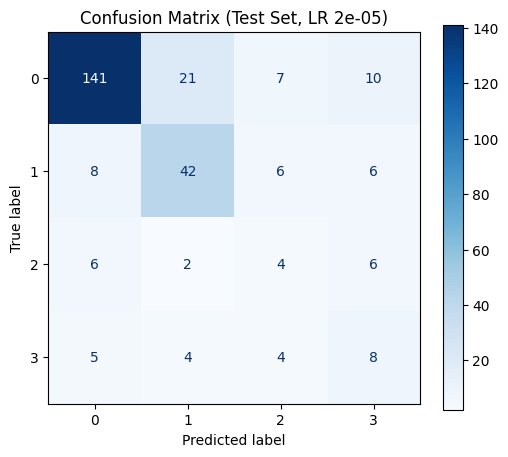

In [ ]:
display_confusion_matrix(true_labels, preds)

#### Considerations
As we can see, even though the dataset has been balanced, the results are still very bad towords the minority classes.